In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
#Data importeren
start_df = pd.read_csv('Datasets/i4talent_2.csv', sep=',')
start_df.head()

,WerknemerID,datum,geboortedatum,indiensttreding_datum,uitdiensttreding_datum,leeftijd,lengte_dienst,stad,afdeling,klant_id,geslacht_id,geslacht,uitdiensttreding_reden,uitdiensttreding_type,STATUS_JAAR,STATUS,BUSINESS_UNIT
0,6962,2018-12-31 05:06:00,1989-06-26 05:06:00,2013-05-23 05:06:00,1905-01-01 05:06:00,29.0,5.0,Amstelveen,BI,30,V,Vrouw,Niet van toepassing,Niet van toepassing,2018,Actief,Detachering
1,6212,2016-12-30 05:06:00,1983-08-25 05:06:00,2010-04-24 05:06:00,1905-01-01 05:06:00,33.0,6.0,Utrecht,Accountant,21,M,Man,Niet van toepassing,Niet van toepassing,2016,Actief,Detachering
2,5325,2018-12-31 05:06:00,1976-04-24 05:06:00,2006-06-09 05:06:00,1905-01-01 05:06:00,42.0,12.0,Amsterdam,BI,42,V,Vrouw,Niet van toepassing,Niet van toepassing,2018,Actief,Detachering
3,8193,2018-12-31 05:06:00,1998-10-26 05:06:00,2018-04-28 05:06:00,1905-01-01 05:06:00,20.0,NaN,Utrecht,BI,21,V,Vrouw,Niet van toepassing,Niet van toepassing,2018,Actief,Detachering
4,5926,2013-12-31 05:06:00,1981-03-19 05:06:00,2009-01-09 05:06:00,1905-01-01 05:06:00,32.0,4.0,Den Haag,Accountant,18,M,Man,Niet van toepassing,Niet van toepassing,2013,Actief,Detachering


# Data cleaning

In [38]:
#uitdiensttredings_type is gelinkt aan uitdeinsttreding_reden, dus die column gaat weg
start_df = start_df.drop('uitdiensttreding_type', axis=1)

In [39]:
#We beginnen met het cleanen van de data
#Columnen krijgen een andere naam om het makkelijker te maken
# Dictionary met nieuwe kolomnamen voor specifieke kolommen
nieuwe_kolomnamen_specifiek = {
    'WerknemerID': 'werknemer_id',
    'datum': 'datum',
    'geboortedatum': 'geboortedatum',
    'indiensttreding_datum': 'startdatum',
    'uitdiensttreding_datum': 'einddatum',
    'leeftijd': 'leeftijd',
    'lengte_dienst': 'dienstperiode',
    'stad': 'stad',
    'afdeling': 'afdeling',
    'klant_id': 'klant_id',
    'geslacht_id': 'geslacht_id',
    'geslacht': 'geslacht',
    'uitdiensttreding_reden': 'uitdienst_reden',
    'STATUS_JAAR': 'status_jaar',
    'STATUS': 'status',
    'BUSINESS_UNIT': 'business_unit',
}

# Hernoem de specifieke kolommen
start_df = start_df.rename(columns=nieuwe_kolomnamen_specifiek)

# Toon het aangepaste DataFrame
print(start_df)


       werknemer_id                datum        geboortedatum  \
0              6962  2018-12-31 05:06:00  1989-06-26 05:06:00   
1              6212  2016-12-30 05:06:00  1983-08-25 05:06:00   
2              5325  2018-12-31 05:06:00  1976-04-24 05:06:00   
3              8193  2018-12-31 05:06:00  1998-10-26 05:06:00   
4              5926  2013-12-31 05:06:00  1981-03-19 05:06:00   
...             ...                  ...                  ...   
49748          6305  2018-12-31 05:06:00  1984-04-20 05:06:00   
49749          8025  2017-12-31 05:06:00  1997-06-25 05:06:00   
49750          2632  2014-12-31 05:06:00  1961-04-27 05:06:00   
49751          7122  2014-12-31 05:06:00  1990-09-08 05:06:00   
49752          7353  2018-12-31 05:06:00  1992-05-28 05:06:00   

                startdatum            einddatum  leeftijd  dienstperiode  \
0      2013-05-23 05:06:00  1905-01-01 05:06:00      29.0            5.0   
1      2010-04-24 05:06:00  1905-01-01 05:06:00      33.0          

In [40]:
#Er missen leeftijden, dus via geboortedatum leeftijden berekend
def fill_age(row):
    if pd.isnull(row['leeftijd']):
        birth_year = pd.to_datetime(row['geboortedatum']).year
        return row['status_jaar'] - birth_year
    else:
        return row['leeftijd']

start_df['leeftijd'] = start_df.apply(fill_age, axis=1)

In [41]:
#leeftijd = 64 wordt geen ontslag, maar pensioen
start_df.loc[(start_df['leeftijd'] == 64) & (start_df['uitdienst_reden'] == 'Ontslag'), 'uitdienst_reden'] = 'Pensioen'

In [42]:
#column lengte dienst aanmaken
start_df['einddatum'] = pd.to_datetime(start_df['einddatum'])
start_df['startdatum'] = pd.to_datetime(start_df['startdatum'])
start_df['datum'] = pd.to_datetime(start_df['datum'])
max_udt = start_df['datum'].max()

def fill_lengte_dienst(row):
    if pd.isnull(row['dienstperiode']):
        indiensttreding_date = row['startdatum']
        uitdiensttreding_date = row['einddatum']
        
        if uitdiensttreding_date.year < 1999:
            lengte_dienst = (max_udt - indiensttreding_date).days / 365.25
        else:
            lengte_dienst = (uitdiensttreding_date - indiensttreding_date).days / 365.25
        
        return int(math.ceil(lengte_dienst))
    else:
        return int(row['dienstperiode'])

start_df['dienstperiode'] = start_df.apply(fill_lengte_dienst, axis=1)


In [43]:
start_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49753 entries, 0 to 49752
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   werknemer_id     49753 non-null  int64         
 1   datum            49753 non-null  datetime64[ns]
 2   geboortedatum    49753 non-null  object        
 3   startdatum       49753 non-null  datetime64[ns]
 4   einddatum        49753 non-null  datetime64[ns]
 5   leeftijd         49753 non-null  float64       
 6   dienstperiode    49753 non-null  int64         
 7   stad             44210 non-null  object        
 8   afdeling         44688 non-null  object        
 9   klant_id         49753 non-null  int64         
 10  geslacht_id      49753 non-null  object        
 11  geslacht         49753 non-null  object        
 12  uitdienst_reden  49753 non-null  object        
 13  status_jaar      49753 non-null  int64         
 14  status           49753 non-null  objec

In [44]:
#value van beeindigd hernoemd
start_df['status'] = start_df['status'].replace({'BeÌÇindigd': 'Beeindigd'})
start_df

,werknemer_id,datum,geboortedatum,startdatum,einddatum,leeftijd,dienstperiode,stad,afdeling,klant_id,geslacht_id,geslacht,uitdienst_reden,status_jaar,status,business_unit
0,6962,2018-12-31 05:06:00,1989-06-26 05:06:00,2013-05-23 05:06:00,1905-01-01 05:06:00,29.0,5,Amstelveen,BI,30,V,Vrouw,Niet van toepassing,2018,Actief,Detachering
1,6212,2016-12-30 05:06:00,1983-08-25 05:06:00,2010-04-24 05:06:00,1905-01-01 05:06:00,33.0,6,Utrecht,Accountant,21,M,Man,Niet van toepassing,2016,Actief,Detachering
2,5325,2018-12-31 05:06:00,1976-04-24 05:06:00,2006-06-09 05:06:00,1905-01-01 05:06:00,42.0,12,Amsterdam,BI,42,V,Vrouw,Niet van toepassing,2018,Actief,Detachering
3,8193,2018-12-31 05:06:00,1998-10-26 05:06:00,2018-04-28 05:06:00,1905-01-01 05:06:00,20.0,3,Utrecht,BI,21,V,Vrouw,Niet van toepassing,2018,Actief,Detachering
4,5926,2013-12-31 05:06:00,1981-03-19 05:06:00,2009-01-09 05:06:00,1905-01-01 05:06:00,32.0,4,Den Haag,Accountant,18,M,Man,Niet van toepassing,2013,Actief,Detachering
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49748,6305,2018-12-31 05:06:00,1984-04-20 05:06:00,2010-08-28 05:06:00,1905-01-01 05:06:00,34.0,11,Rotterdam,Business analist,46,V,Vrouw,Niet van toepassing,2018,Actief,Detachering
49749,8025,2017-12-31 05:06:00,1997-06-25 05:06:00,2017-08-12 05:06:00,2019-02-12 05:06:00,20.0,0,Amsterdam,NaN,44,M,Man,Niet van toepassing,2017,Actief,Detachering
49750,2632,2014-12-31 05:06:00,1961-04-27 05:06:00,1998-07-09 05:06:00,1905-01-01 05:06:00,53.0,16,Haarlem,Business analist,5,V,Vrouw,Niet van toepassing,2014,Actief,Detachering
49751,7122,2014-12-31 05:06:00,1990-09-08 05:06:00,2014-01-10 05:06:00,2019-12-30 05:06:00,24.0,0,Barendrecht,Credit controller,13,M,Man,Niet van toepassing,2014,Actief,Detachering


In [45]:
#Zorgt ervoor dat column status overeenkomt met uitdiensttrending datum
start_df['einddatum'] = pd.to_datetime(start_df['einddatum'])

start_df['status_Actief'] = start_df.apply(lambda row: 1 if row['einddatum'].year < 1906 else 0, axis=1)

start_df['status_Beeindigd'] = start_df.apply(lambda row: 0 if row['einddatum'].year < 1906 else 1, axis=1)


In [46]:
#Bij de column stad missen er values, die worden de value overig
start_df['stad'] = start_df['stad'].fillna('Overige')


# Visualisatie

array([[<Axes: title={'center': 'werknemer_id'}>,
        <Axes: title={'center': 'datum'}>,
        <Axes: title={'center': 'startdatum'}>],
       [<Axes: title={'center': 'einddatum'}>,
        <Axes: title={'center': 'leeftijd'}>,
        <Axes: title={'center': 'dienstperiode'}>],
       [<Axes: title={'center': 'klant_id'}>,
        <Axes: title={'center': 'status_jaar'}>,
        <Axes: title={'center': 'status_Actief'}>],
       [<Axes: title={'center': 'status_Beeindigd'}>, <Axes: >, <Axes: >]],
      dtype=object)

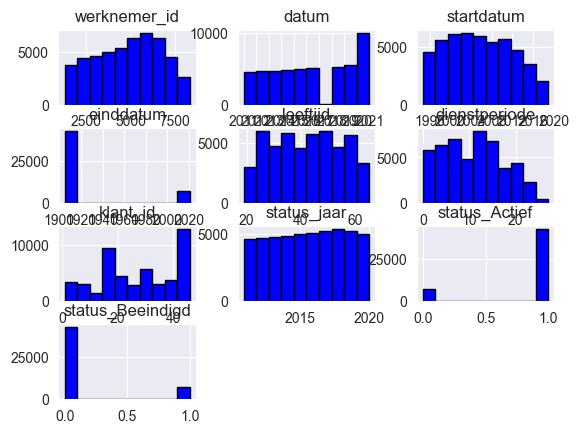

In [47]:
#Kijken voor outliers
start_df.hist(color='blue', edgecolor='black')

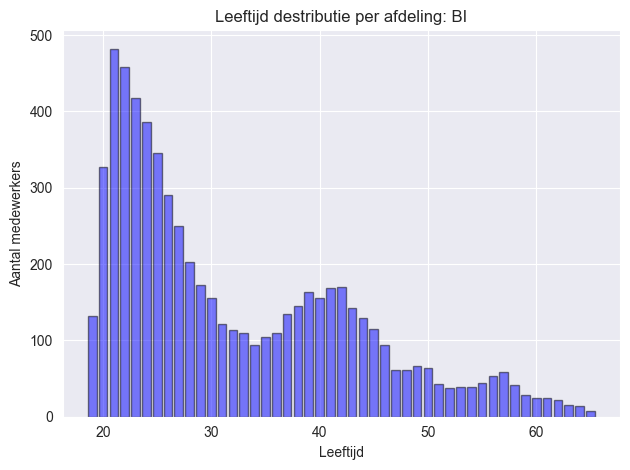

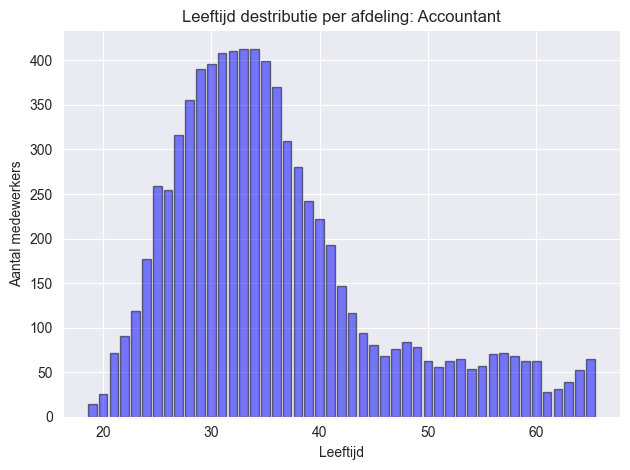

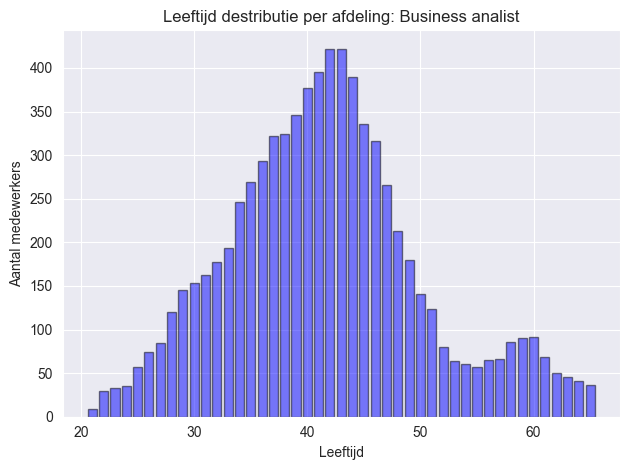

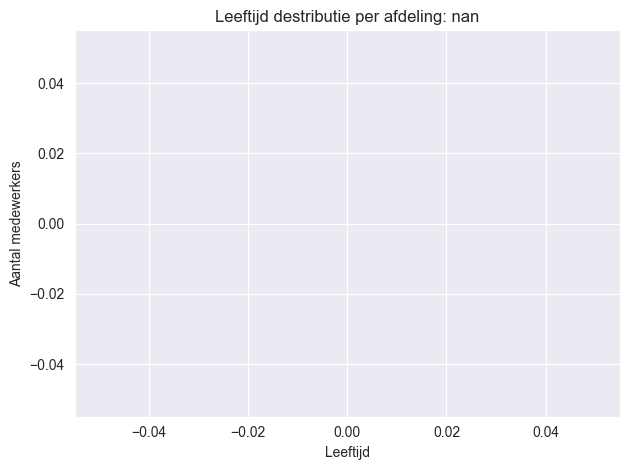

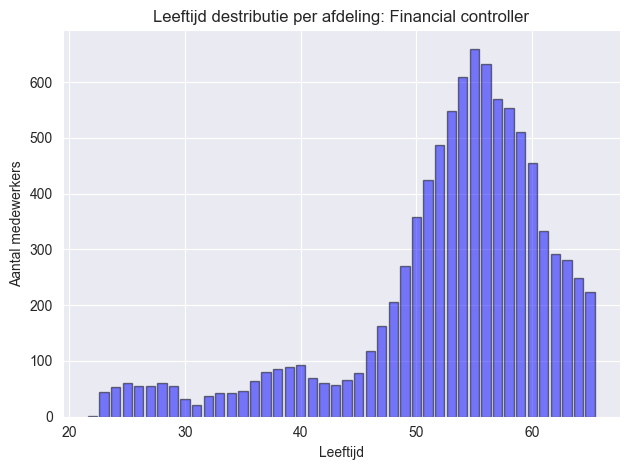

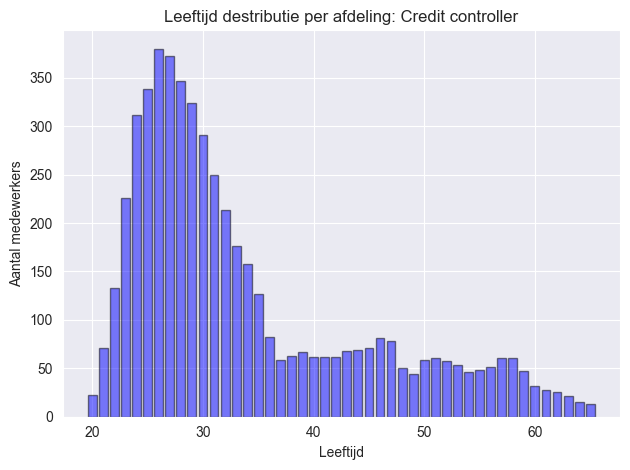

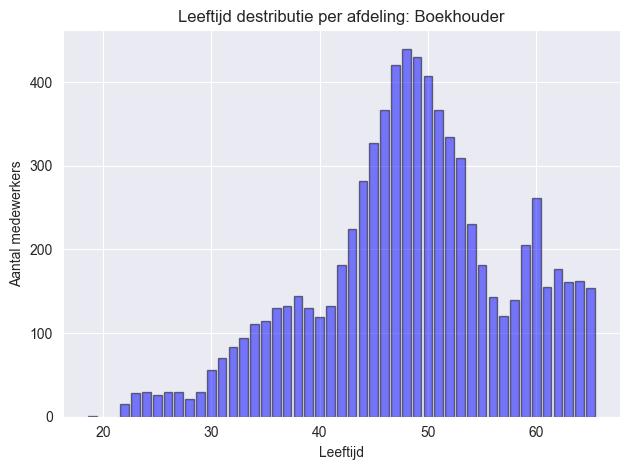

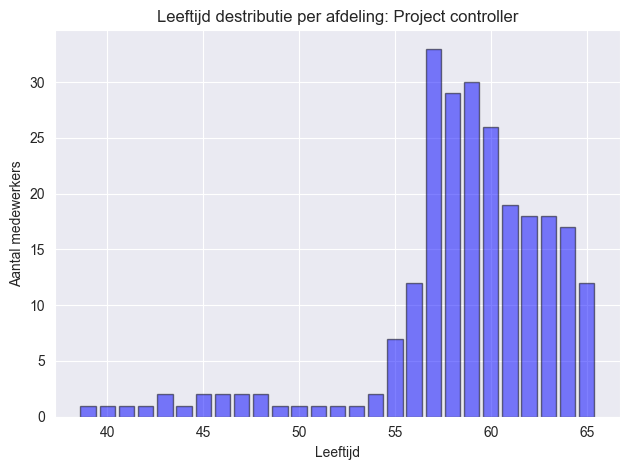

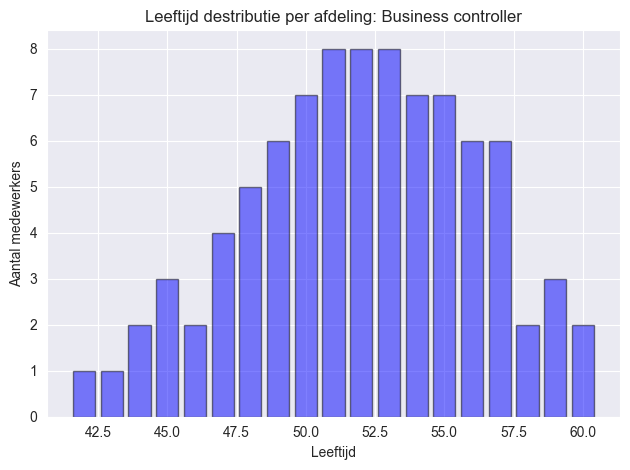

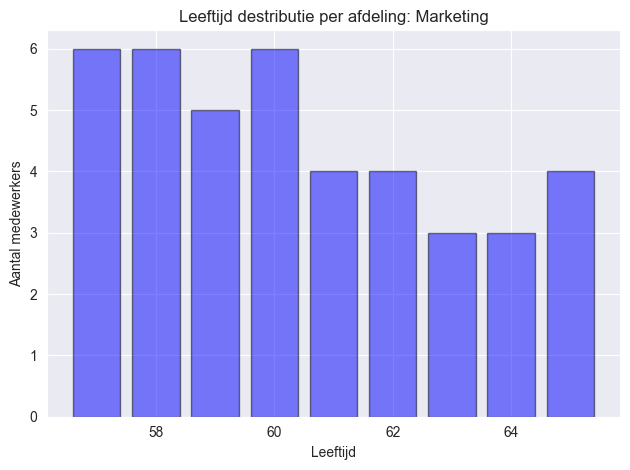

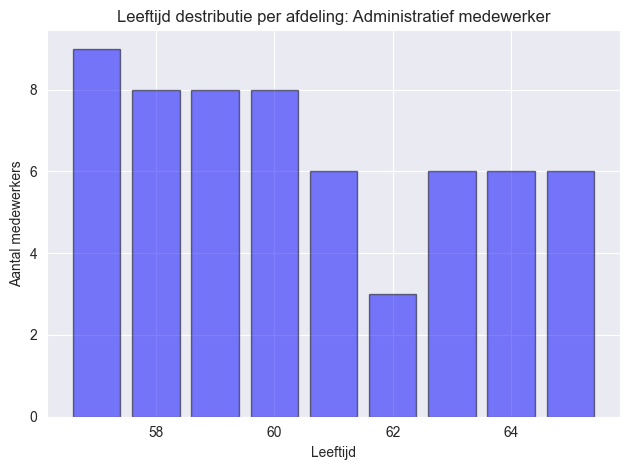

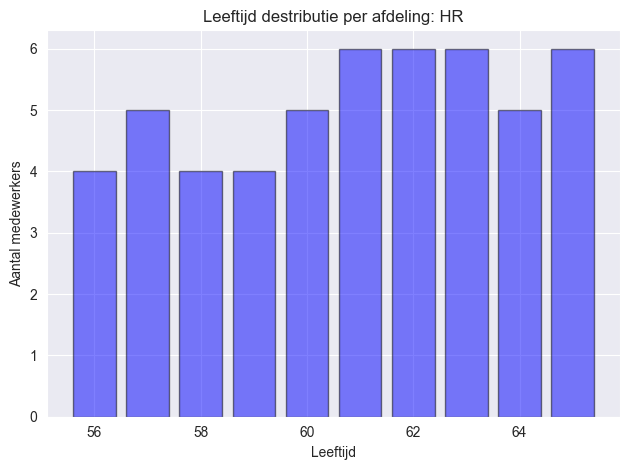

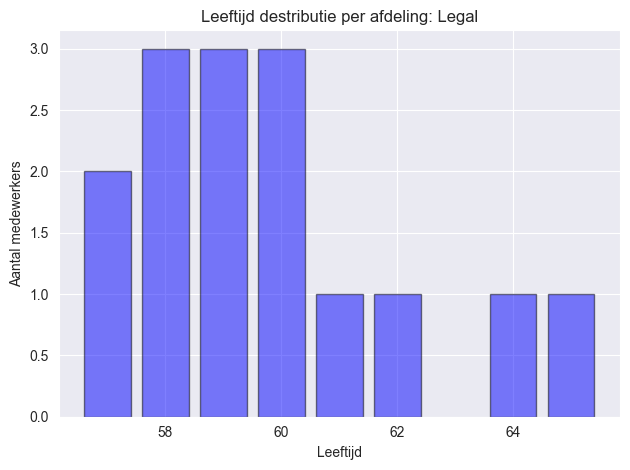

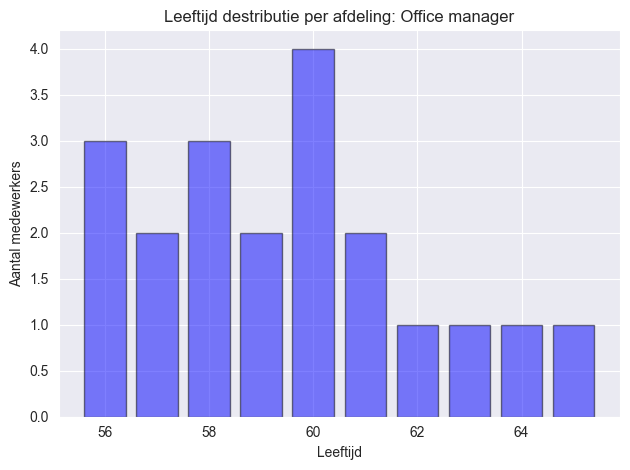

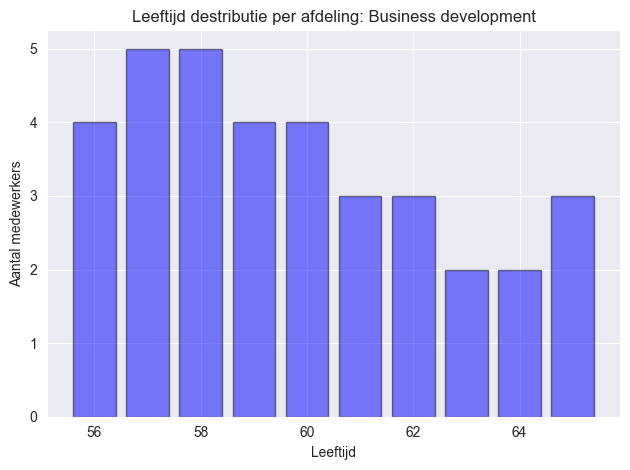

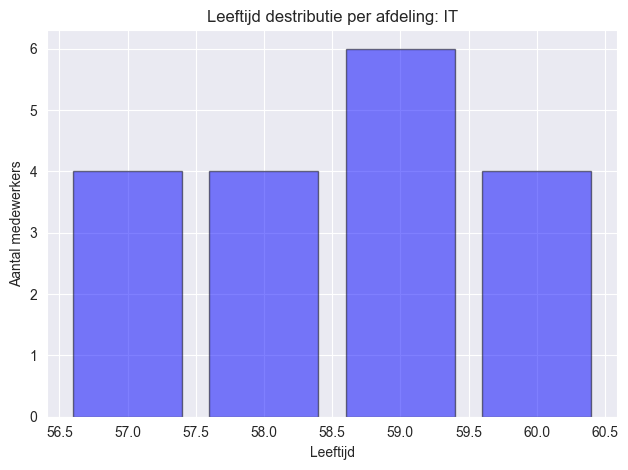

In [48]:
#leeftijd distributie per afdeling
list_of_departments = start_df['afdeling'].unique().tolist()

for department in list_of_departments:
    department_df = start_df[start_df['afdeling'] == department]
    department_age_counts = department_df['leeftijd'].value_counts().sort_index()
    
    plt.bar(department_age_counts.index, department_age_counts.values, color='blue', edgecolor='black', alpha=0.5)
    plt.xlabel('Leeftijd')
    plt.ylabel('Aantal medewerkers')
    plt.title(f'Leeftijd destributie per afdeling: {department}')
    plt.tight_layout()
    plt.show()

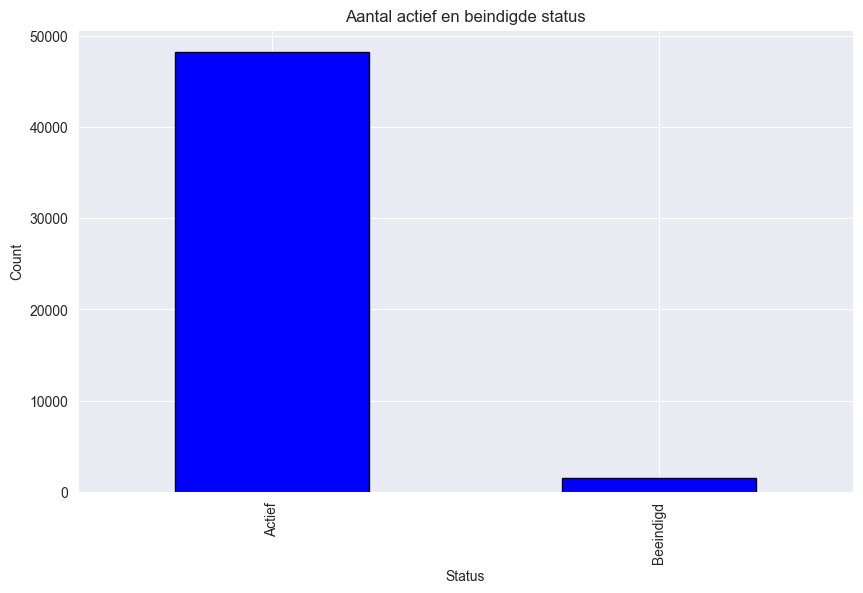

In [49]:
#Visualizaties
#Aantal actief en aantal beindigde status
start_stad_counts = start_df['status'].value_counts()
plt.figure(figsize=(10, 6))
start_stad_counts.plot(kind='bar', color='blue', edgecolor='black')
plt.title('Aantal actief en beindigde status')
plt.xlabel('Status')
plt.ylabel('Count')
plt.show()

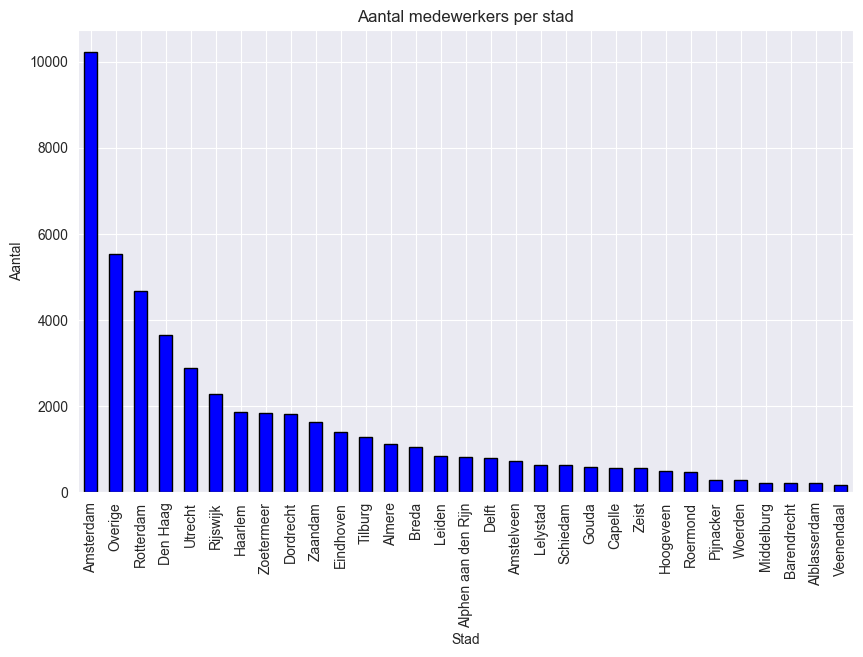

In [50]:
#Histogram aantal medewerkers per stad
start_stad_counts = start_df['stad'].value_counts()
plt.figure(figsize=(10, 6))
start_stad_counts.plot(kind='bar', color='blue', edgecolor='black')
plt.title('Aantal medewerkers per stad')
plt.xlabel('Stad')
plt.ylabel('Aantal')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

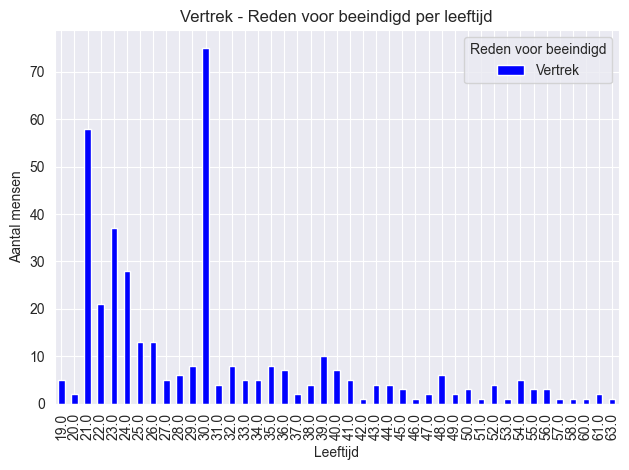

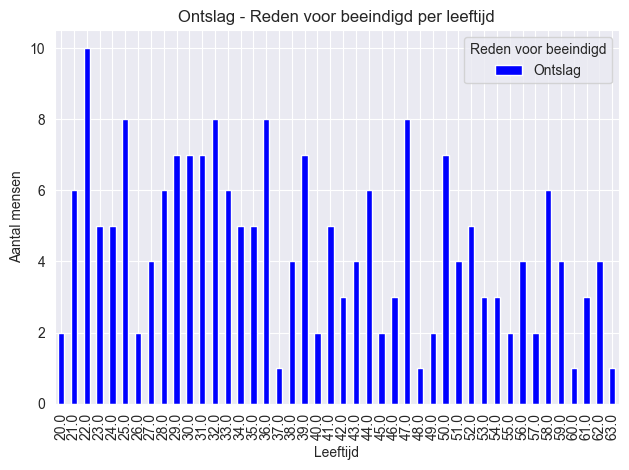

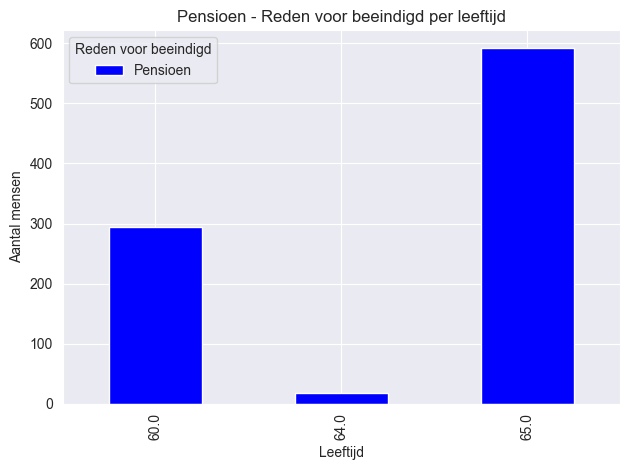

In [51]:

count_df = start_df.groupby(['leeftijd', 'uitdienst_reden']).size().reset_index(name='Count')
unique_reasons = count_df['uitdienst_reden'].unique()

for reason in unique_reasons:
    if reason == 'Niet van toepassing':
        continue
    
    reason_df = count_df[count_df['uitdienst_reden'] == reason]
    pivot_df = reason_df.pivot(index='leeftijd', columns='uitdienst_reden', values='Count').fillna(0)
    pivot_df.plot(kind='bar', stacked=False, color = 'blue')
    plt.xlabel('Leeftijd')
    plt.ylabel('Aantal mensen')
    plt.title(f'{reason} - Reden voor beeindigd per leeftijd')
    plt.legend(title='Reden voor beeindigd')
    plt.tight_layout()
plt.show

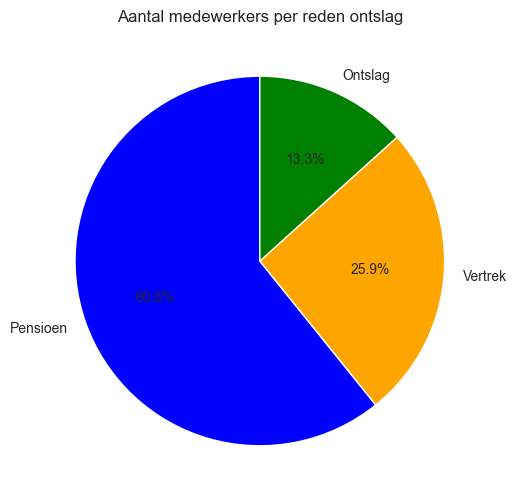

In [52]:
#Pie-chart aantal medewerkers per reden ontslag
pie_start_df = start_df[start_df['uitdienst_reden'] != 'Niet van toepassing']
start_stad_counts = pie_start_df['uitdienst_reden'].value_counts()
plt.figure(figsize=(10, 6))
plt.pie(start_stad_counts, labels=start_stad_counts.index, autopct='%1.1f%%', startangle=90, colors=['blue', 'orange', 'green', 'red'])
plt.title('Aantal medewerkers per reden ontslag')
plt.show()

# Visualisatie zonder uitdiensttreding reden pensioen

In [53]:

df = start_df[start_df['uitdienst_reden'] != 'Pensioen']
print(df.head)

<bound method NDFrame.head of        werknemer_id               datum        geboortedatum  \
0              6962 2018-12-31 05:06:00  1989-06-26 05:06:00   
1              6212 2016-12-30 05:06:00  1983-08-25 05:06:00   
2              5325 2018-12-31 05:06:00  1976-04-24 05:06:00   
3              8193 2018-12-31 05:06:00  1998-10-26 05:06:00   
4              5926 2013-12-31 05:06:00  1981-03-19 05:06:00   
...             ...                 ...                  ...   
49748          6305 2018-12-31 05:06:00  1984-04-20 05:06:00   
49749          8025 2017-12-31 05:06:00  1997-06-25 05:06:00   
49750          2632 2014-12-31 05:06:00  1961-04-27 05:06:00   
49751          7122 2014-12-31 05:06:00  1990-09-08 05:06:00   
49752          7353 2018-12-31 05:06:00  1992-05-28 05:06:00   

               startdatum           einddatum  leeftijd  dienstperiode  \
0     2013-05-23 05:06:00 1905-01-01 05:06:00      29.0              5   
1     2010-04-24 05:06:00 1905-01-01 05:06:00      33

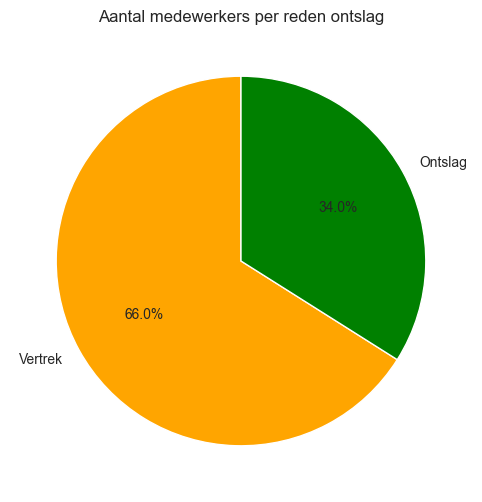

In [54]:
pie_df = df[df['uitdienst_reden'] != 'Niet van toepassing']
stad_counts = pie_df['uitdienst_reden'].value_counts()
plt.figure(figsize=(10, 6))
plt.pie(stad_counts, labels=stad_counts.index, autopct='%1.1f%%', startangle=90, colors=['orange', 'green'])
plt.title('Aantal medewerkers per reden ontslag')
plt.show()

status                     Actief  Beeindigd  Totaal  Percentage Beeindigd
afdeling                                                                  
Accountant                   7596        105    7701              1.363459
Administratief medewerker      51          1      52              1.923077
BI                           6201        223    6424              3.471357
Boekhouder                   7390         35    7425              0.471380
Business analist             7451         46    7497              0.613579
Business controller            88          0      88              0.000000
Business development           30          0      30              0.000000
Credit controller            5257         63    5320              1.184211
Financial controller         8959         44    9003              0.488726
HR                             45          0      45              0.000000
IT                             14          0      14              0.000000
Legal                    

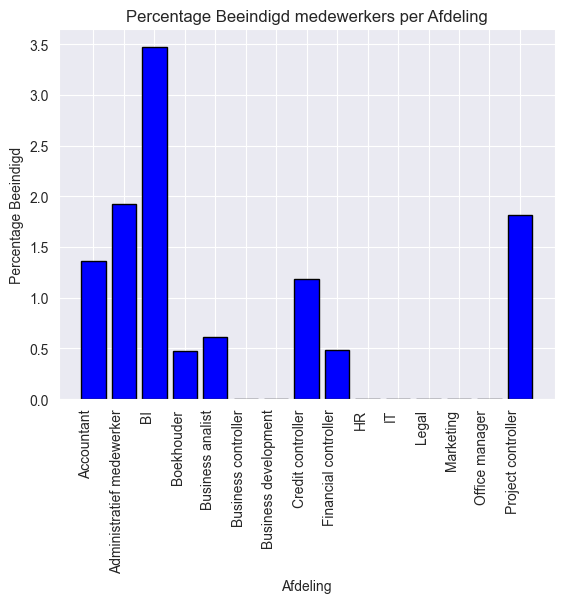

In [55]:
#histogram percentage beeindigde medewerkers per afdeling
aantal_mensen_per_afdeling_status = df.groupby(['afdeling', 'status']).size().unstack(fill_value=0)
aantal_mensen_per_afdeling_status['Totaal'] = aantal_mensen_per_afdeling_status.sum(axis=1)

aantal_mensen_per_afdeling_status['Percentage Beeindigd'] = (
    aantal_mensen_per_afdeling_status['Beeindigd'] / aantal_mensen_per_afdeling_status['Totaal'] * 100
)

print(aantal_mensen_per_afdeling_status)
plt.bar(aantal_mensen_per_afdeling_status.index, aantal_mensen_per_afdeling_status['Percentage Beeindigd'], color='blue', edgecolor='black')
plt.xlabel('Afdeling')
plt.ylabel('Percentage Beeindigd')
plt.title('Percentage Beeindigd medewerkers per Afdeling')
plt.xticks(rotation=90, ha='right')
plt.show()


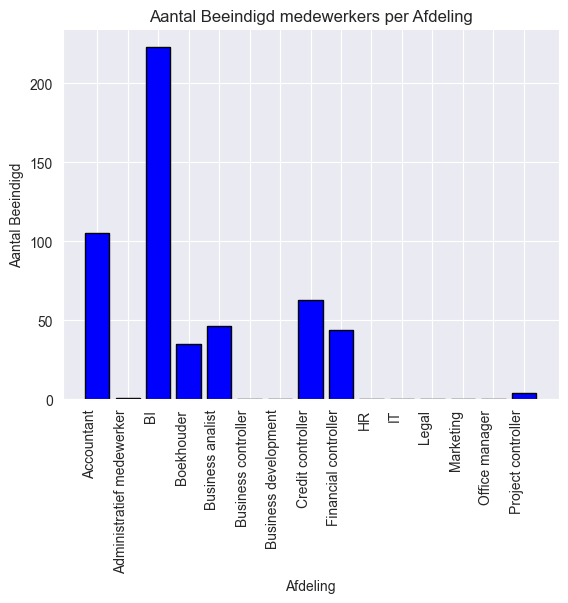

In [56]:
#histogram beeindigde medewerkers per afdeling
plt.bar(aantal_mensen_per_afdeling_status.index, aantal_mensen_per_afdeling_status['Beeindigd'], color='blue', edgecolor='black')
plt.xlabel('Afdeling')
plt.ylabel('Aantal Beeindigd')
plt.title('Aantal Beeindigd medewerkers per Afdeling')
plt.xticks(rotation=90, ha='right')
plt.show()


/var/folders/h6/jcdx533j7414r00pkwz6gynr0000gn/T/ipykernel_21170/3265821166.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dienstperiode'] = pd.to_numeric(df['dienstperiode'], errors='coerce')


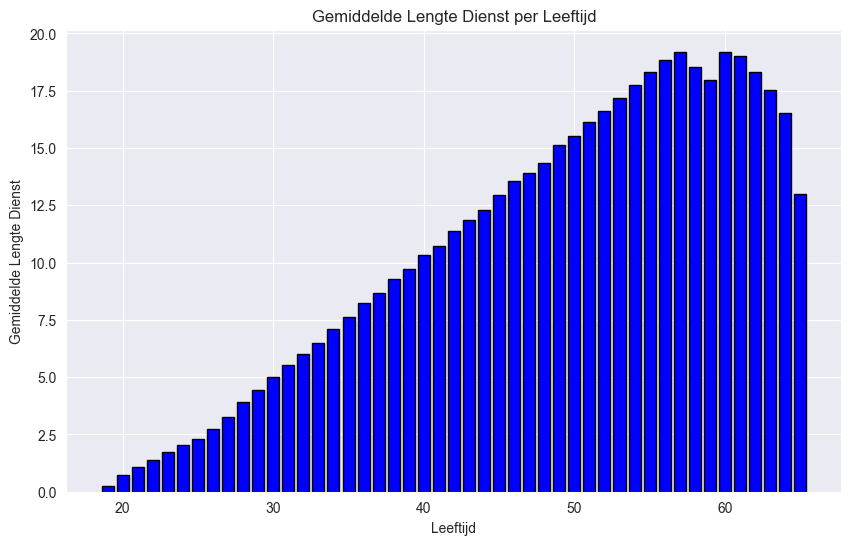

In [57]:
#gemiddelde lengte dienst per leeftijd
df['dienstperiode'] = pd.to_numeric(df['dienstperiode'], errors='coerce')

average_lengte_dienst_per_leeftijd = df.groupby('leeftijd')['dienstperiode'].mean()

plt.figure(figsize=(10, 6))
plt.bar(average_lengte_dienst_per_leeftijd.index, average_lengte_dienst_per_leeftijd, color='blue', edgecolor='black')

plt.title('Gemiddelde Lengte Dienst per Leeftijd')
plt.xlabel('Leeftijd')
plt.ylabel('Gemiddelde Lengte Dienst')
plt.show()

/var/folders/h6/jcdx533j7414r00pkwz6gynr0000gn/T/ipykernel_21170/3099746036.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dienstperiode'] = pd.to_numeric(df['dienstperiode'], errors='coerce')


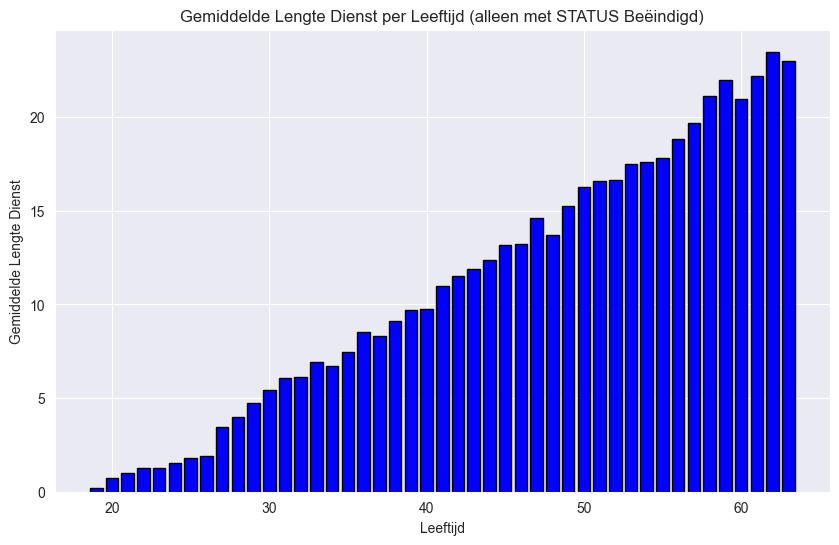

In [58]:
#Gemiddelde Lengte Dienst per Leeftijd (alleen met STATUS Beëindigd)
df['dienstperiode'] = pd.to_numeric(df['dienstperiode'], errors='coerce')
beindigd_data = df[df['status'] == 'Beeindigd']
average_lengte_dienst_per_leeftijd = beindigd_data.groupby('leeftijd')['dienstperiode'].mean()

plt.figure(figsize=(10, 6))
plt.bar(average_lengte_dienst_per_leeftijd.index, average_lengte_dienst_per_leeftijd, color='blue', edgecolor='black')

plt.title('Gemiddelde Lengte Dienst per Leeftijd (alleen met STATUS Beëindigd)')
plt.xlabel('Leeftijd')
plt.ylabel('Gemiddelde Lengte Dienst')
plt.show()

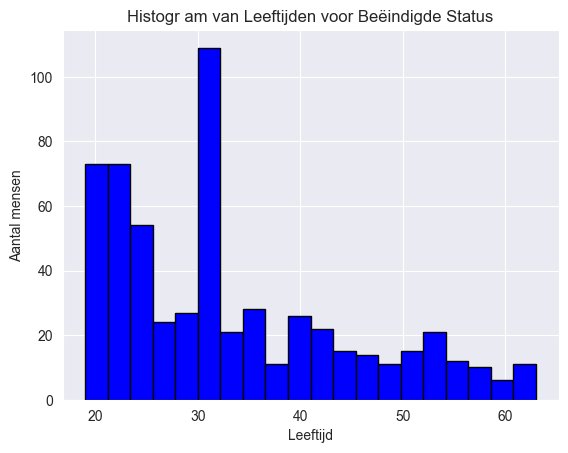

In [59]:
#histogram beeindige status per leeftijd
beeindigd_data = df[df['status'] == 'Beeindigd']
plt.hist(beeindigd_data['leeftijd'], bins=20, color='blue', edgecolor='black')

plt.title('Histogr am van Leeftijden voor Beëindigde Status')
plt.xlabel('Leeftijd')
plt.ylabel('Aantal mensen')
plt.show()


/var/folders/h6/jcdx533j7414r00pkwz6gynr0000gn/T/ipykernel_21170/3718252464.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['leeftijd'] = pd.to_numeric(df['leeftijd'], errors='coerce')


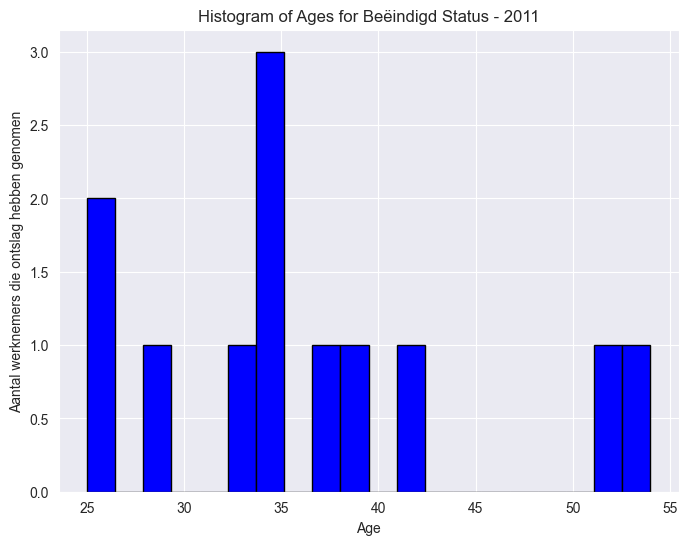

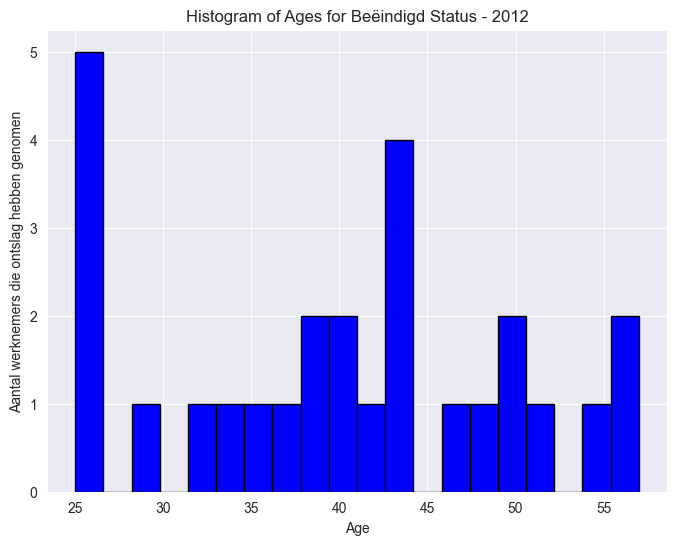

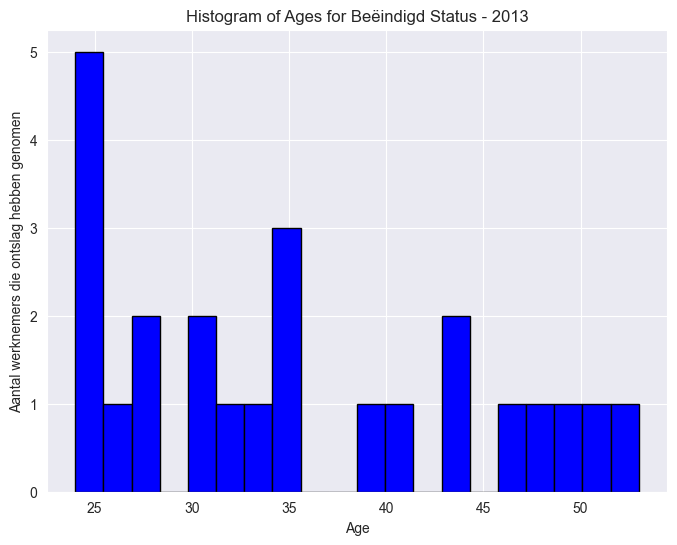

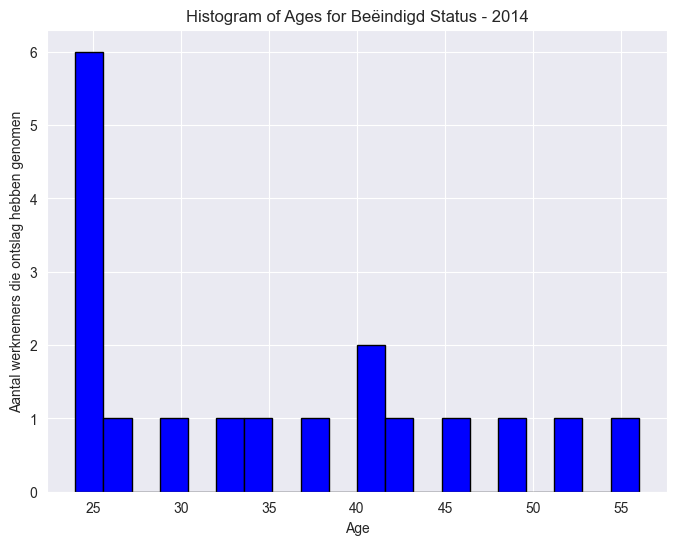

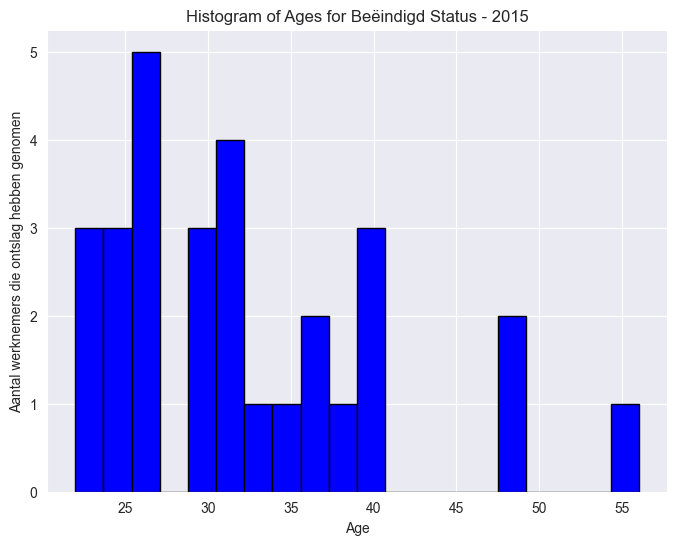

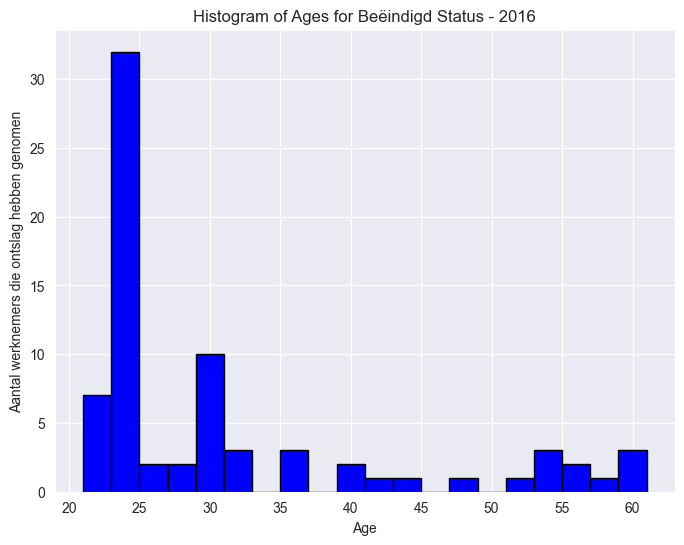

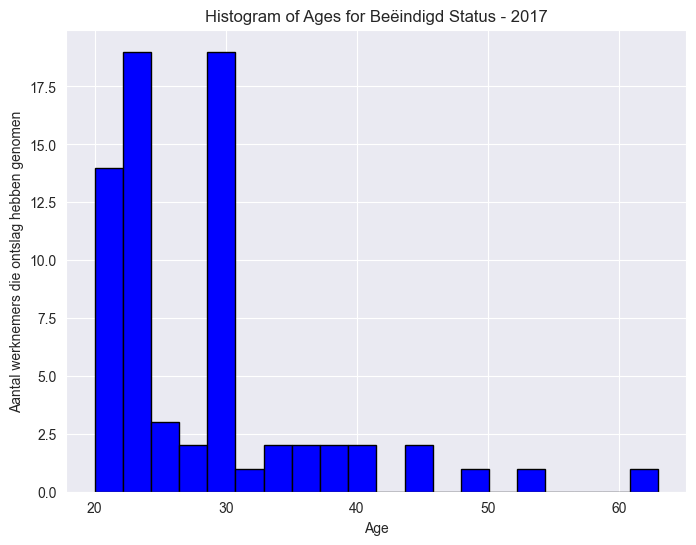

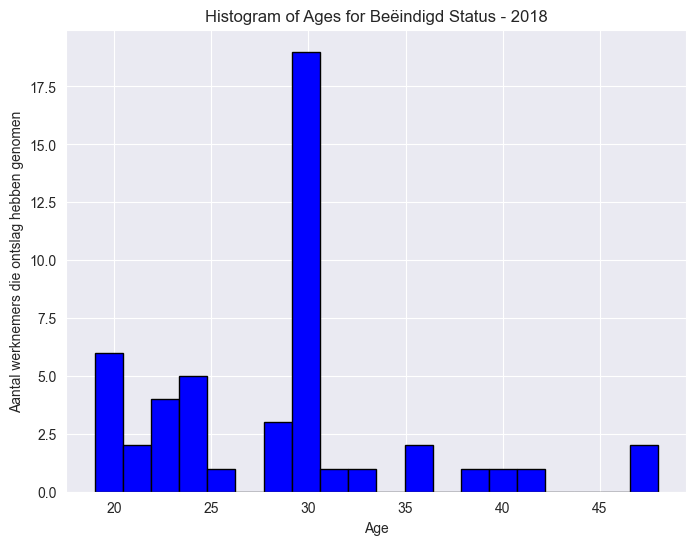

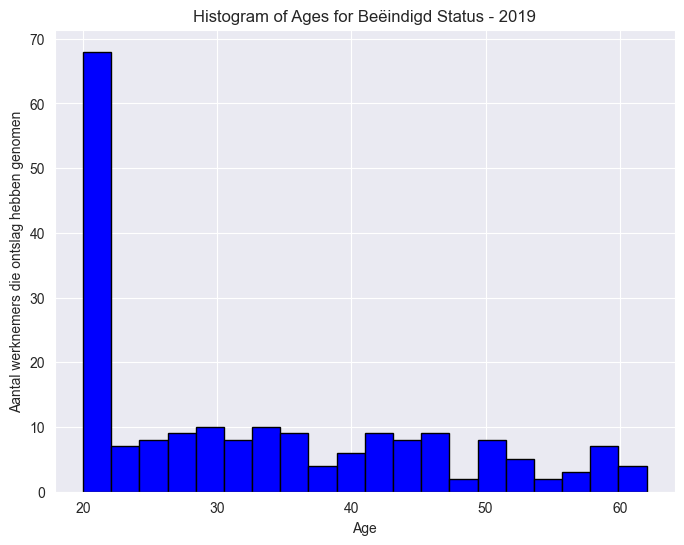

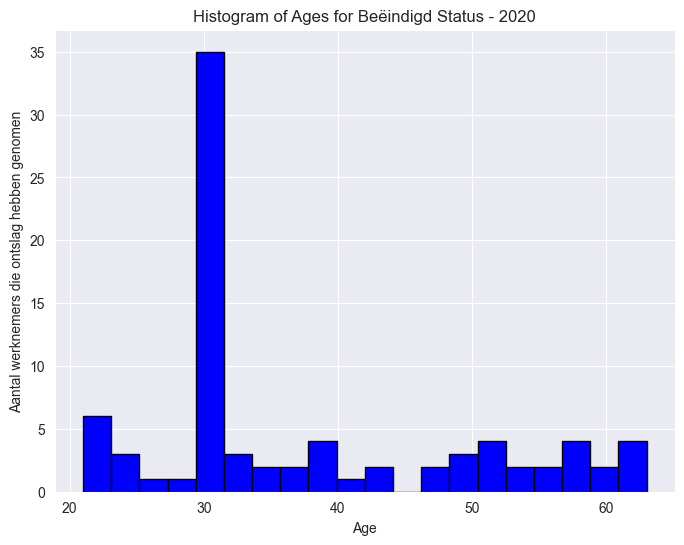

In [60]:
#histogram beeindigd medewerker per leeftijd per jaar
df['leeftijd'] = pd.to_numeric(df['leeftijd'], errors='coerce')
beindigd_data = df[df['status'] == 'Beeindigd']

for year in range(2011, 2021):
    current_year_data = beindigd_data[beindigd_data['datum'].dt.year == year]

    plt.figure(figsize=(8, 6))
    plt.hist(current_year_data['leeftijd'], bins=20, color='blue', edgecolor='black')

    plt.title(f'Histogram of Ages for Beëindigd Status - {year}')
    plt.xlabel('Age')
    plt.ylabel('Aantal werknemers die ontslag hebben genomen')
    plt.show()

In [61]:
#Alle steden die niet bekend zijn worden via een KNN wel bepaald.
df_without_overige = df[df['stad'] != 'Overige'].copy()
df_overige = df[df['stad'] == 'Overige'].copy()
features = ['leeftijd', 'status_jaar', 'dienstperiode']
X_overige = df_without_overige[features]
y_overige = df_without_overige['stad']
X_train, X_test, y_train, y_test = train_test_split(X_overige, y_overige, test_size=0.2, random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
predicted_cities = knn.predict(df_overige[features])
df_overige['stad'] = predicted_cities

df = pd.concat([df_without_overige, df_overige], ignore_index=True)
print(df)


       werknemer_id               datum        geboortedatum  \
0              6962 2018-12-31 05:06:00  1989-06-26 05:06:00   
1              6212 2016-12-30 05:06:00  1983-08-25 05:06:00   
2              5325 2018-12-31 05:06:00  1976-04-24 05:06:00   
3              8193 2018-12-31 05:06:00  1998-10-26 05:06:00   
4              5926 2013-12-31 05:06:00  1981-03-19 05:06:00   
...             ...                 ...                  ...   
48844          7068 2020-12-30 05:06:00  1990-04-06 05:06:00   
48845          4253 2014-12-31 05:06:00  1969-09-30 05:06:00   
48846          2516 2020-12-30 05:06:00  1960-09-25 05:06:00   
48847          5788 2019-12-31 05:06:00  1980-01-12 05:06:00   
48848          7353 2018-12-31 05:06:00  1992-05-28 05:06:00   

               startdatum           einddatum  leeftijd  dienstperiode  \
0     2013-05-23 05:06:00 1905-01-01 05:06:00      29.0              5   
1     2010-04-24 05:06:00 1905-01-01 05:06:00      33.0              6   
2     200

In [62]:
#Een nieuwe column waarin staat wat de afstand tot amsterdam is van de steden
coordinates = {
    'Amstelveen': (52.3121, 4.8704),
    'Utrecht': (52.0907, 5.1214),
    'Amsterdam': (52.3676, 4.9041),
    'Den Haag': (52.0705, 4.3007),
    'Leiden': (52.1601, 4.4970),
    'Dordrecht': (51.8133, 4.6901),
    'Barendrecht': (51.8530, 4.5343),
    'Eindhoven': (51.4416, 5.4697),
    'Breda': (51.5719, 4.7683),
    'Tilburg': (51.5555, 5.0913),
    'Rotterdam': (51.9225, 4.4792),
    'Rijswijk': (52.0377, 4.3214),
    'Haarlem': (52.3874, 4.6462),
    'Zaandam': (52.4387, 4.8183),
    'Gouda': (52.0116, 4.7104),
    'Schiedam': (51.9194, 4.3883),
    'Zeist': (52.0907, 5.1804),
    'Middelburg': (51.4988, 3.6100),
    'Almere': (52.3508, 5.2647),
    'Zoetermeer': (52.0571, 4.4936),
    'Veenendaal': (52.0289, 5.5580),
    'Delft': (52.0116, 4.3571),
    'Hoogeveen': (52.7227, 6.4901),
    'Lelystad': (52.5185, 5.4714),
    'Roermond': (51.1942, 5.9871),
    'Alphen aan den Rijn': (52.1277, 4.6575),
    'Capelle': (51.9304, 4.5809),
    'Pijnacker': (52.0153, 4.4255),
    'Alblasserdam': (51.8625, 4.6600),
    'Woerden': (52.0848, 4.8835)
}

def calculate_distance(lat1, lon1, lat2, lon2):
    R = 6371 

    d_lat = math.radians(lat2 - lat1)
    d_lon = math.radians(lon2 - lon1)

    a = math.sin(d_lat / 2) ** 2 + math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.sin(d_lon / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    distance = R * c
    return distance

amsterdam_lat, amsterdam_lon = 52.3676, 4.9041

distances = []
for index, row in df.iterrows():
    city_name = row['stad']
    if city_name in coordinates:
        city_lat, city_lon = coordinates[city_name]
        distance = calculate_distance(amsterdam_lat, amsterdam_lon, city_lat, city_lon)
        distances.append(int(distance))
    elif city_name == 'Overige':
        distances.append('Onbekend')
    else:
        distances.append('Onbekend') 
        print(f"Coordinates not found for city: {city_name}")      

df['afstand_tot_amsterdam'] = distances
print(df.head())

   werknemer_id               datum        geboortedatum          startdatum  \
0          6962 2018-12-31 05:06:00  1989-06-26 05:06:00 2013-05-23 05:06:00   
1          6212 2016-12-30 05:06:00  1983-08-25 05:06:00 2010-04-24 05:06:00   
2          5325 2018-12-31 05:06:00  1976-04-24 05:06:00 2006-06-09 05:06:00   
3          8193 2018-12-31 05:06:00  1998-10-26 05:06:00 2018-04-28 05:06:00   
4          5926 2013-12-31 05:06:00  1981-03-19 05:06:00 2009-01-09 05:06:00   

            einddatum  leeftijd  dienstperiode        stad    afdeling  \
0 1905-01-01 05:06:00      29.0              5  Amstelveen          BI   
1 1905-01-01 05:06:00      33.0              6     Utrecht  Accountant   
2 1905-01-01 05:06:00      42.0             12   Amsterdam          BI   
3 1905-01-01 05:06:00      20.0              3     Utrecht          BI   
4 1905-01-01 05:06:00      32.0              4    Den Haag  Accountant   

   klant_id geslacht_id geslacht      uitdienst_reden  status_jaar  status

# Dummies creeren

In [63]:
#Dummies
#Dummie uitdiensttreding reden
#df = pd.get_dummies(df, columns=['uitdienst_reden'])
dummies = pd.get_dummies(df['uitdienst_reden'], prefix='uitdienst_reden')
df = pd.concat([df, dummies], axis=1)

In [64]:
df.columns

Index(['werknemer_id', 'datum', 'geboortedatum', 'startdatum', 'einddatum',
       'leeftijd', 'dienstperiode', 'stad', 'afdeling', 'klant_id',
       'geslacht_id', 'geslacht', 'uitdienst_reden', 'status_jaar', 'status',
       'business_unit', 'status_Actief', 'status_Beeindigd',
       'afstand_tot_amsterdam', 'uitdienst_reden_Niet van toepassing',
       'uitdienst_reden_Ontslag', 'uitdienst_reden_Vertrek'],
      dtype='object')

In [65]:
#Dummie afdeling
df = pd.get_dummies(df, columns=['afdeling'])

In [66]:
#Dummie business unit
df = pd.get_dummies(df, columns=['business_unit'])

In [67]:
#Maak dummie voor gender_id
dummy_row_gender = pd.get_dummies(df['geslacht'], prefix='geslacht_id')
df = pd.concat([df, dummy_row_gender], axis=1)
df.columns

Index(['werknemer_id', 'datum', 'geboortedatum', 'startdatum', 'einddatum',
       'leeftijd', 'dienstperiode', 'stad', 'klant_id', 'geslacht_id',
       'geslacht', 'uitdienst_reden', 'status_jaar', 'status', 'status_Actief',
       'status_Beeindigd', 'afstand_tot_amsterdam',
       'uitdienst_reden_Niet van toepassing', 'uitdienst_reden_Ontslag',
       'uitdienst_reden_Vertrek', 'afdeling_Accountant',
       'afdeling_Administratief medewerker', 'afdeling_BI',
       'afdeling_Boekhouder', 'afdeling_Business analist',
       'afdeling_Business controller', 'afdeling_Business development',
       'afdeling_Credit controller', 'afdeling_Financial controller',
       'afdeling_HR', 'afdeling_IT', 'afdeling_Legal', 'afdeling_Marketing',
       'afdeling_Office manager', 'afdeling_Project controller',
       'business_unit_Detachering', 'business_unit_Intern', 'geslacht_id_Man',
       'geslacht_id_Vrouw'],
      dtype='object')

# Visualisaties met dummies 

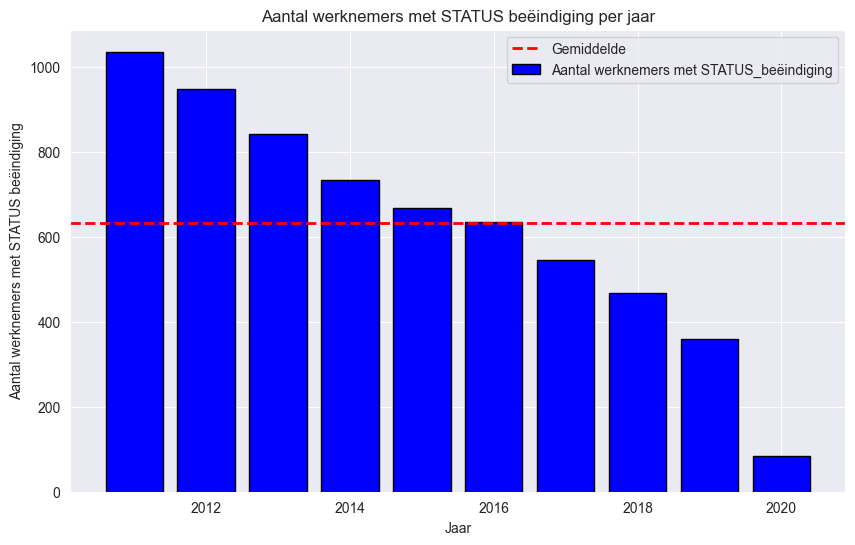

In [68]:
#Visualisaties met dummies
#Histogram van het aantal werknemers met STATUS beëindiging per jaar

df_beindigd = df[df['status_Beeindigd'] == 1]

plt.figure(figsize=(10, 6))
plt.bar(df_beindigd['status_jaar'].value_counts().index, df_beindigd['status_jaar'].value_counts().values, color='blue', edgecolor='black', label='Aantal werknemers met STATUS_beëindiging')
plt.axhline(y=df_beindigd['status_jaar'].value_counts().mean(), color='red', linestyle='dashed', linewidth=2, label='Gemiddelde')

plt.xlabel('Jaar')
plt.ylabel('Aantal werknemers met STATUS beëindiging')
plt.title('Aantal werknemers met STATUS beëindiging per jaar')
plt.legend()
plt.show()



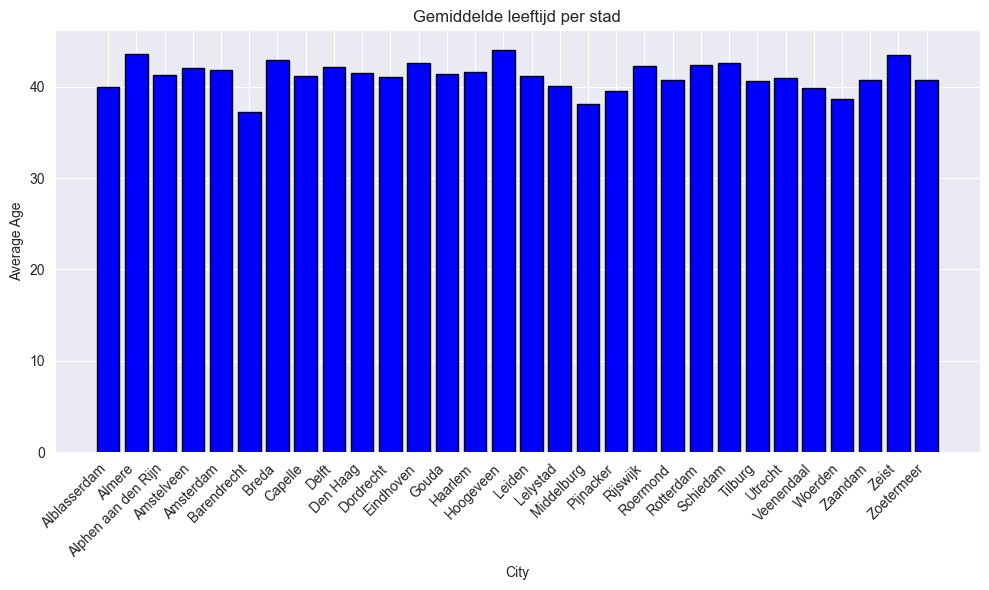

In [69]:
#deze plot is gemaakt om te zien of de leeftijd erg verschilt per stad, dit blijkt mee te vallen
#hierdoor is er gekozen om geen andere technieken te gebruiken dan de modus om NaN values in stad in te vullen met Overige
import pandas as pd
import matplotlib.pyplot as plt

average_age_per_city = df.groupby('stad')['leeftijd'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.bar(average_age_per_city['stad'], average_age_per_city['leeftijd'], color='blue', edgecolor='black')
plt.xlabel('City')
plt.ylabel('Average Age')
plt.title('Gemiddelde leeftijd per stad')
plt.xticks(rotation=45, ha='right')  
plt.tight_layout()

plt.show()


/var/folders/h6/jcdx533j7414r00pkwz6gynr0000gn/T/ipykernel_21170/1886389759.py:11: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:blue'` for the same effect.

  sns.barplot(x='stad', y='Count', hue='Reason', data=melted_reasons, color='blue', edgecolor='black')


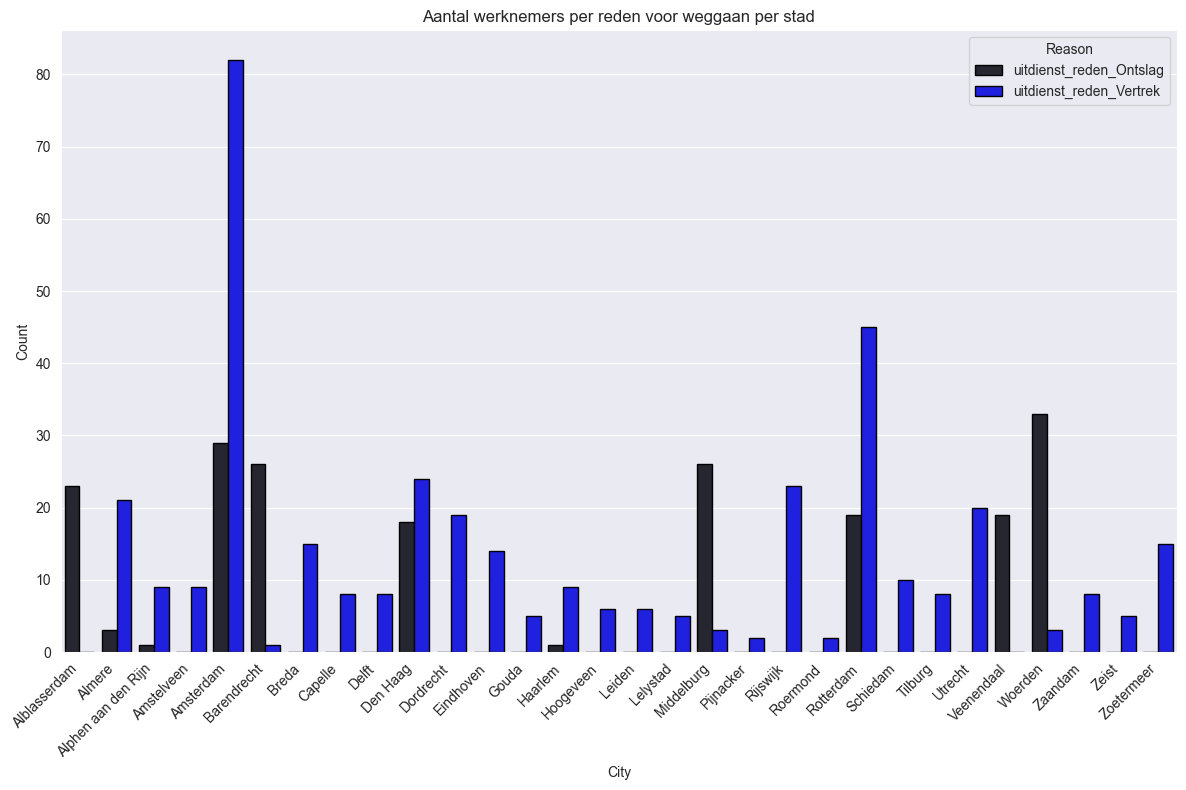

In [70]:
#om te onderzoeken in welke steden er veel uitstroom van werknemers is maken we deze plot
reasons_df = df[['stad', 'uitdienst_reden_Ontslag', 'uitdienst_reden_Vertrek']]

reasons_df = reasons_df.fillna(0)

reasons_count_per_city = reasons_df.groupby('stad').sum().reset_index()

melted_reasons = pd.melt(reasons_count_per_city, id_vars='stad', var_name='Reason', value_name='Count')

plt.figure(figsize=(12, 8))
sns.barplot(x='stad', y='Count', hue='Reason', data=melted_reasons, color='blue', edgecolor='black')
plt.xlabel('City')
plt.ylabel('Count')
plt.title('Aantal werknemers per reden voor weggaan per stad')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()


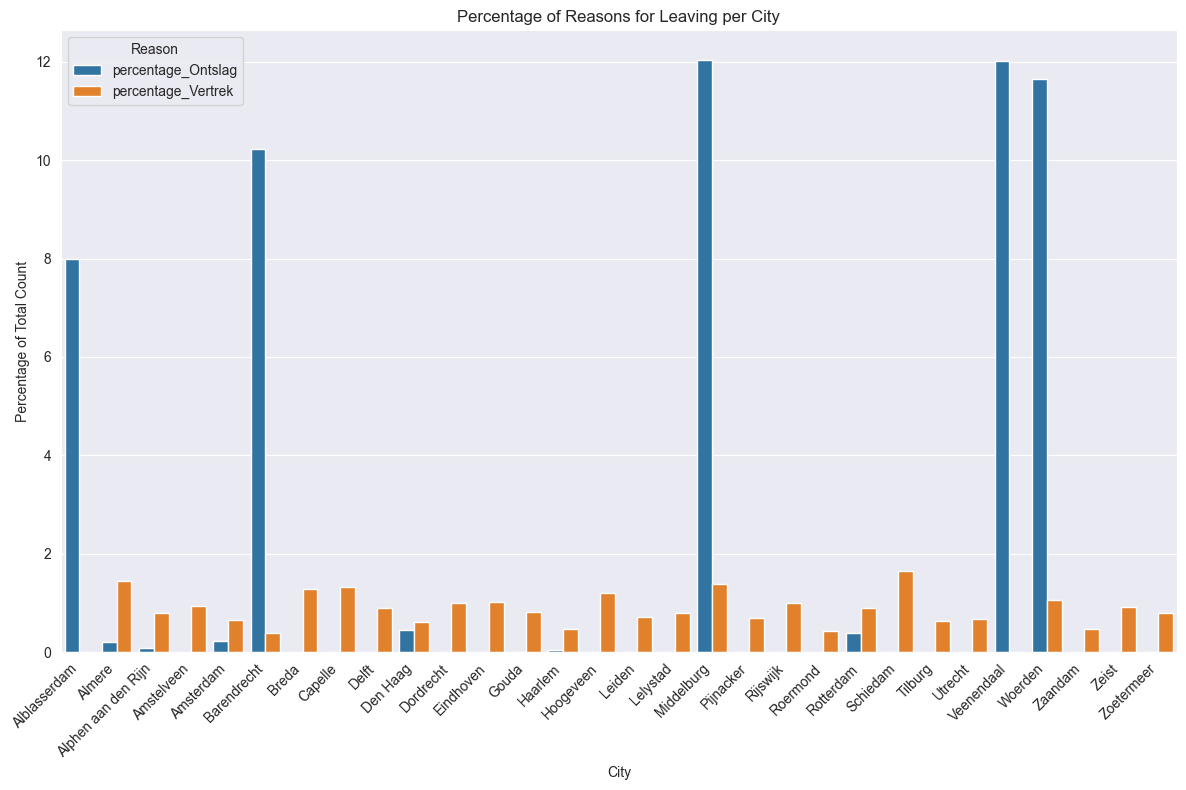

In [71]:
df['stad'] = df['stad'].fillna('Overige')

reasons_df = df[['stad', 'uitdienst_reden_Ontslag', 'uitdienst_reden_Vertrek']]

reasons_df = reasons_df.fillna(0)

reasons_count_per_city = reasons_df.groupby('stad').sum().reset_index()

total_count_per_city = df['stad'].value_counts().reset_index()
total_count_per_city.columns = ['stad', 'total_count']

merged_df = pd.merge(reasons_count_per_city, total_count_per_city, on='stad')

merged_df['percentage_Ontslag'] = (merged_df['uitdienst_reden_Ontslag'] / merged_df['total_count']) * 100
merged_df['percentage_Vertrek'] = (merged_df['uitdienst_reden_Vertrek'] / merged_df['total_count']) * 100

melted_reasons = pd.melt(merged_df, id_vars='stad', var_name='Reason', value_name='Percentage')

melted_reasons = melted_reasons[melted_reasons['Reason'].isin(['percentage_Ontslag', 'percentage_Vertrek'])]

plt.figure(figsize=(12, 8))
sns.barplot(x='stad', y='Percentage', hue='Reason', data=melted_reasons)
plt.xlabel('City')
plt.ylabel('Percentage of Total Count')
plt.title('Percentage of Reasons for Leaving per City')
plt.xticks(rotation=45, ha='right') 
plt.tight_layout()

plt.show()

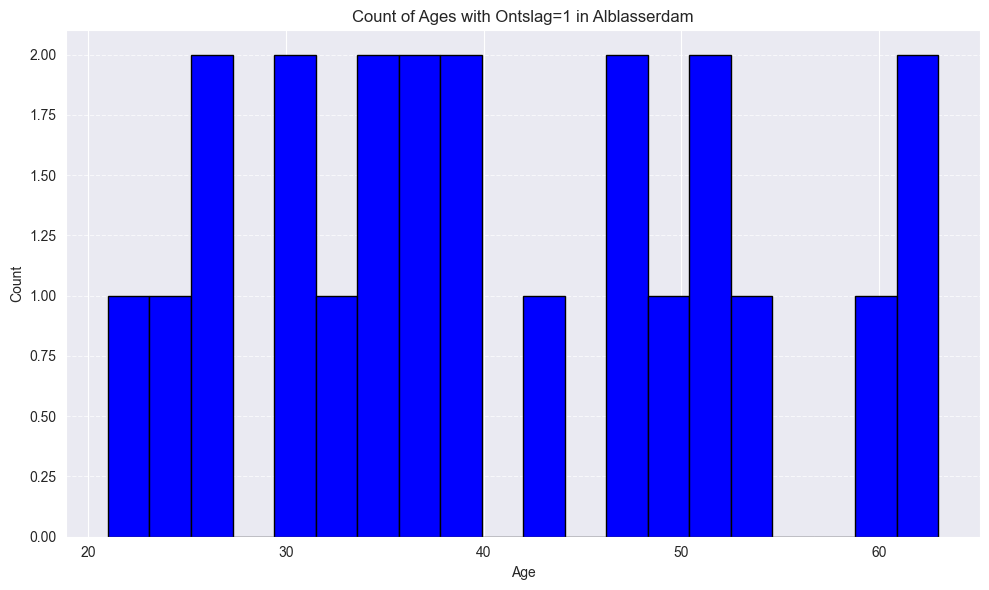

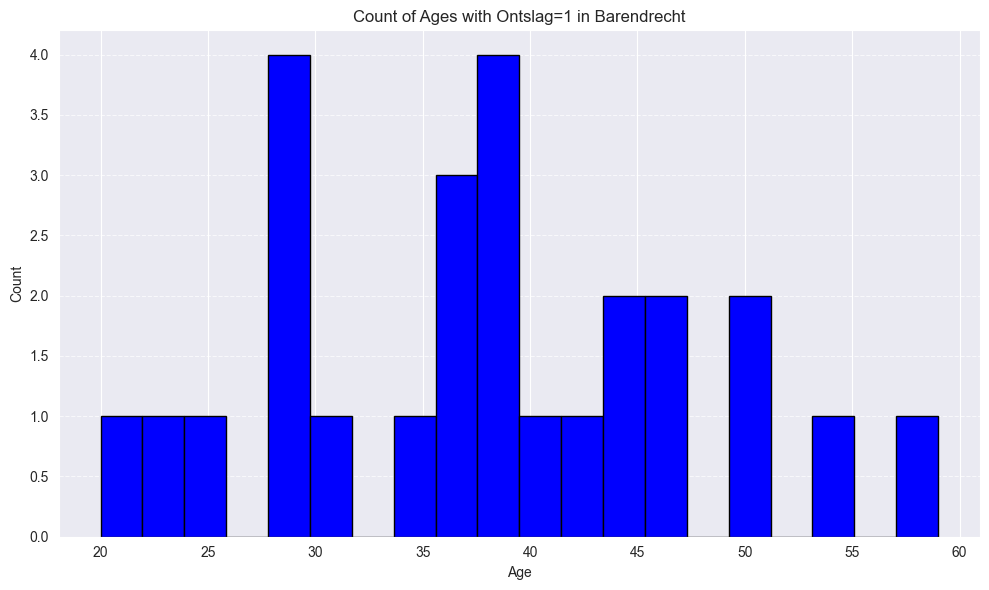

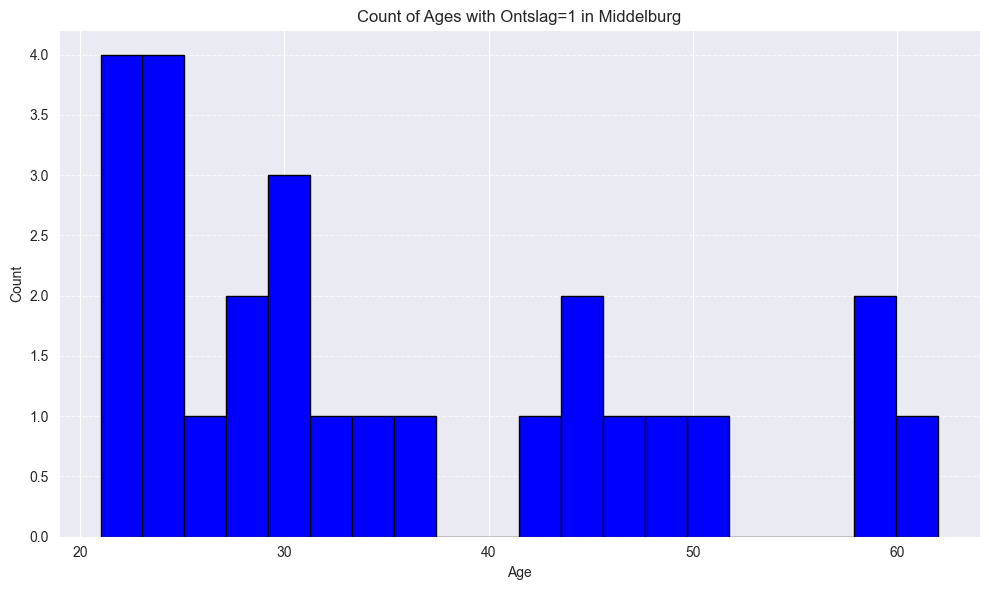

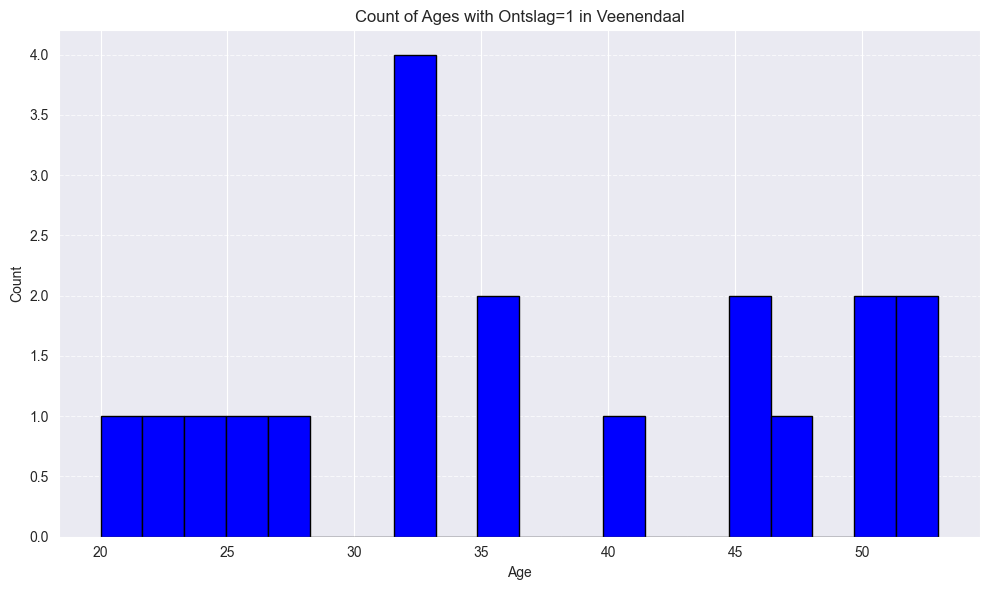

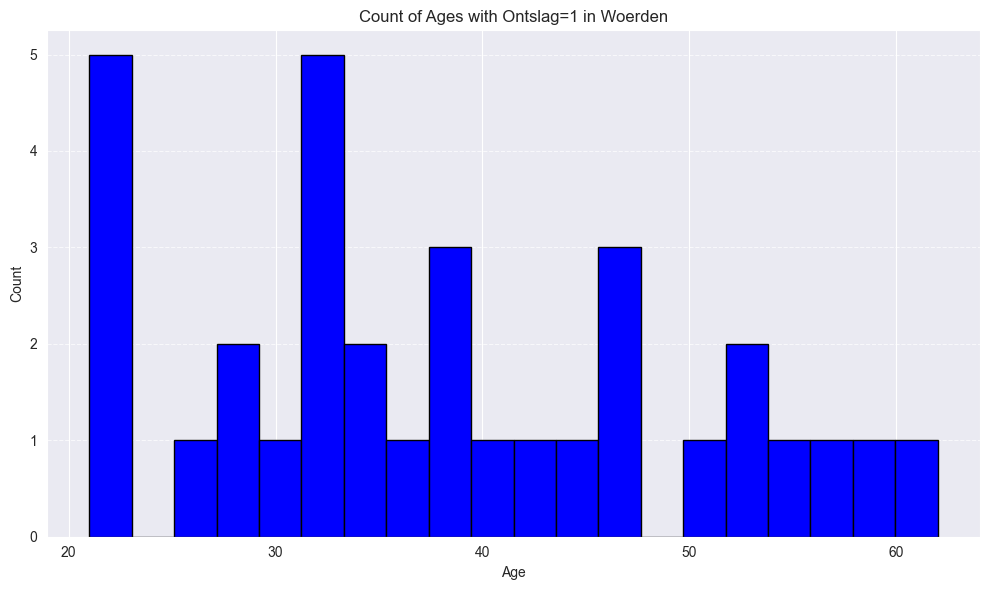

In [72]:
#om te bekijken wat de leeftijdsverdeling van uitgestroomde werknemers is per piek in de vertrekken per stad
#is deze plot gemaakt
cities_to_plot = ['Alblasserdam', 'Barendrecht', 'Middelburg', 'Veenendaal', 'Woerden']

for city in cities_to_plot:
    filtered_df = df[(df['uitdienst_reden_Ontslag'] == 1) & (df['stad'] == city)]

    plt.figure(figsize=(10, 6))
    plt.hist(filtered_df['leeftijd'], bins=20, color='blue', edgecolor='black')
    plt.xlabel('Age')
    plt.ylabel('Count')
    plt.title(f'Count of Ages with Ontslag=1 in {city}')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    plt.show()


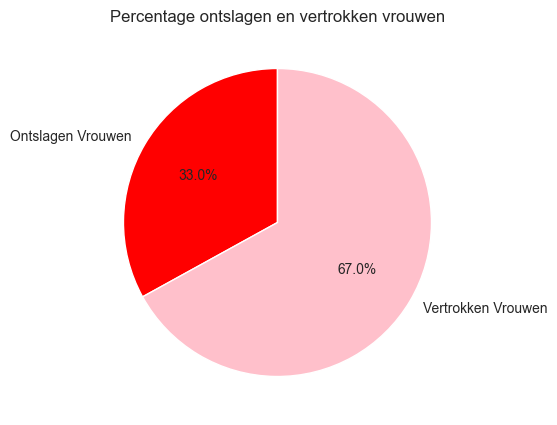

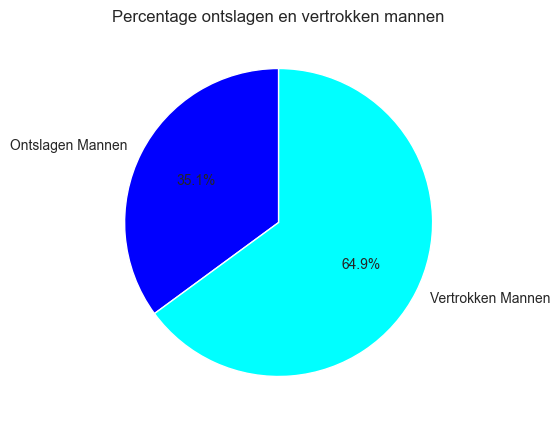

In [73]:
#percentages mannen en vrouwen, vertrokken en ontslagen
leaving_age_df = df[df['uitdienst_reden'] != 'Niet van toepassing']

percentage_ontslagen_mannen = (leaving_age_df[leaving_age_df['geslacht_id_Man'] == 1]['uitdienst_reden_Ontslag'].sum() / len(leaving_age_df[leaving_age_df['geslacht_id_Man'] == 1])) * 100
percentage_vertrokken_mannen = (leaving_age_df[leaving_age_df['geslacht_id_Man'] == 1]['uitdienst_reden_Vertrek'].sum() / len(leaving_age_df[leaving_age_df['geslacht_id_Man'] == 1])) * 100

percentage_ontslagen_vrouwen = (leaving_age_df[leaving_age_df['geslacht_id_Vrouw'] == 1]['uitdienst_reden_Ontslag'].sum() / len(leaving_age_df[leaving_age_df['geslacht_id_Vrouw'] == 1])) * 100
percentage_vertrokken_vrouwen = (leaving_age_df[leaving_age_df['geslacht_id_Vrouw'] == 1]['uitdienst_reden_Vertrek'].sum() / len(leaving_age_df[leaving_age_df['geslacht_id_Vrouw'] == 1])) * 100

plt.figure(figsize=(10, 5))
labels = ['Ontslagen Vrouwen', 'Vertrokken Vrouwen']
sizes = [percentage_ontslagen_vrouwen, percentage_vertrokken_vrouwen]
colors = ['red', 'pink']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Percentage ontslagen en vertrokken vrouwen')
plt.show()

plt.figure(figsize=(10, 5))
labels = ['Ontslagen Mannen', 'Vertrokken Mannen']
sizes = [percentage_ontslagen_mannen, percentage_vertrokken_mannen]
colors = ['blue', 'cyan']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Percentage ontslagen en vertrokken mannen')
plt.show()


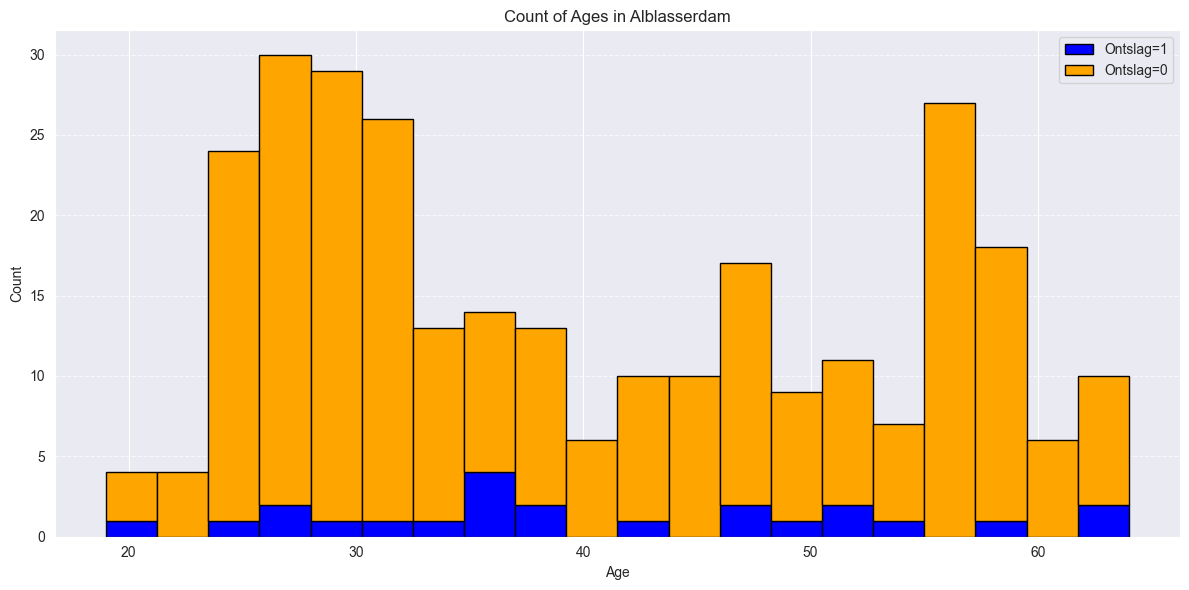

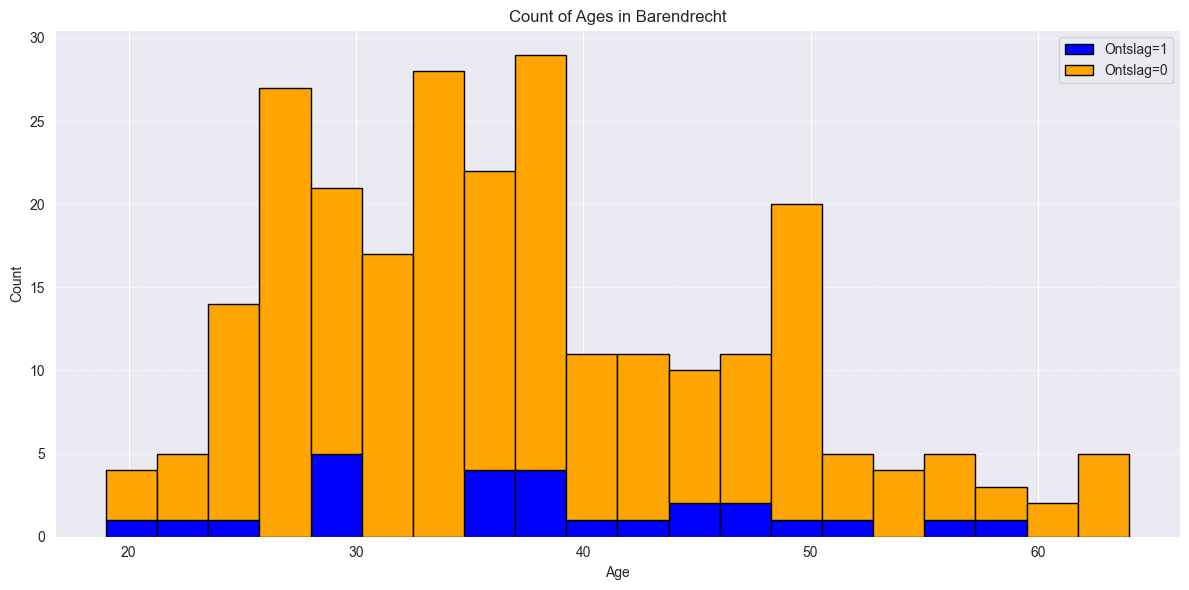

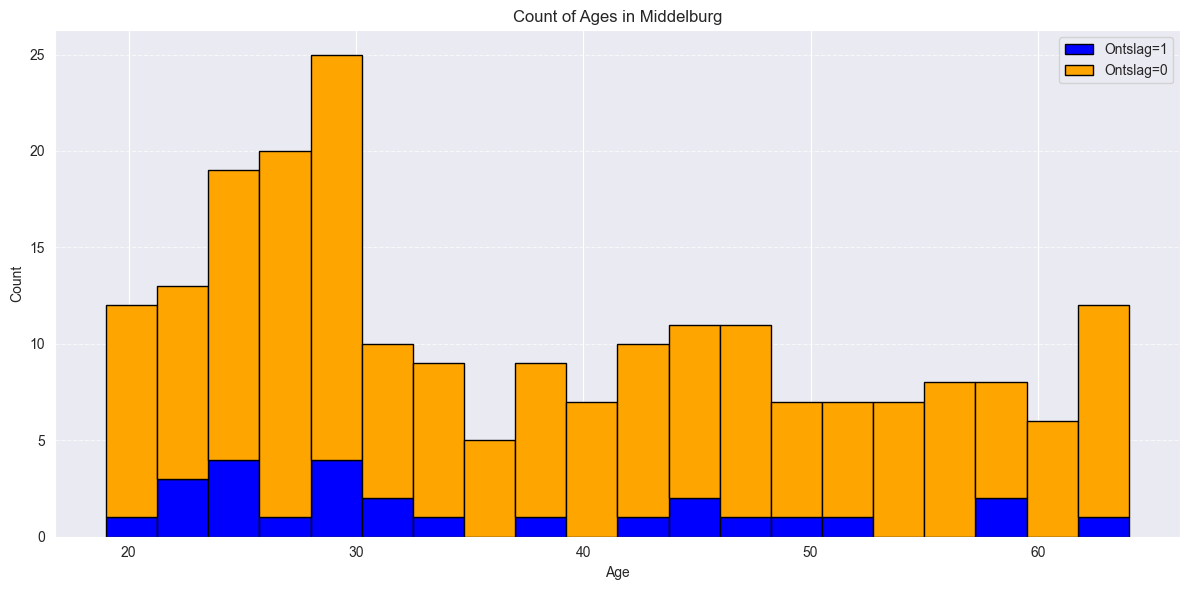

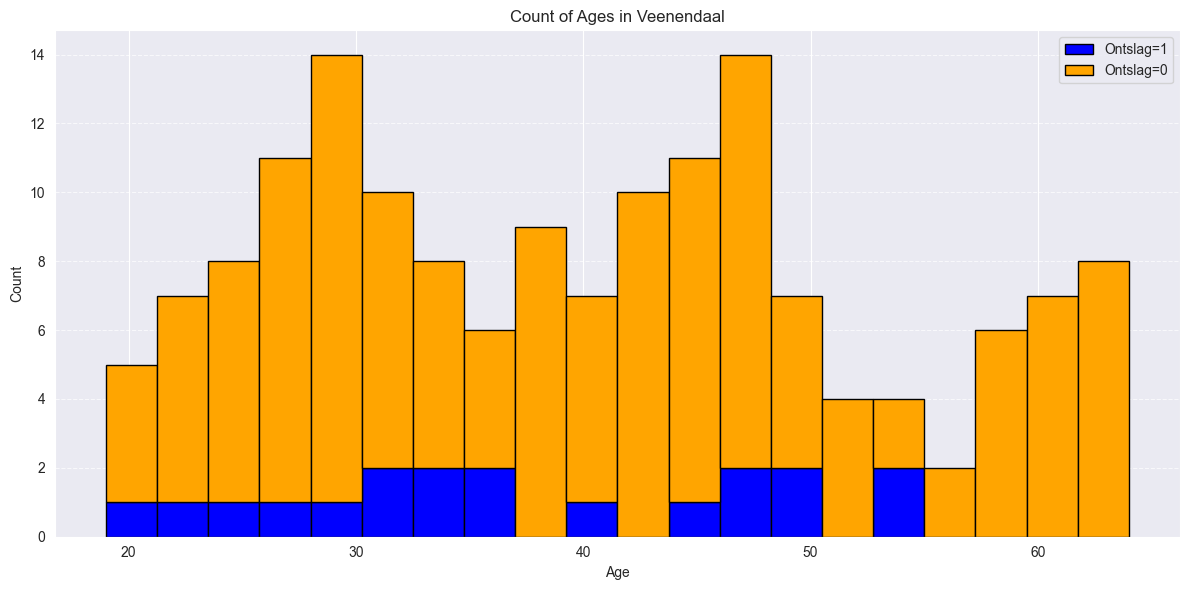

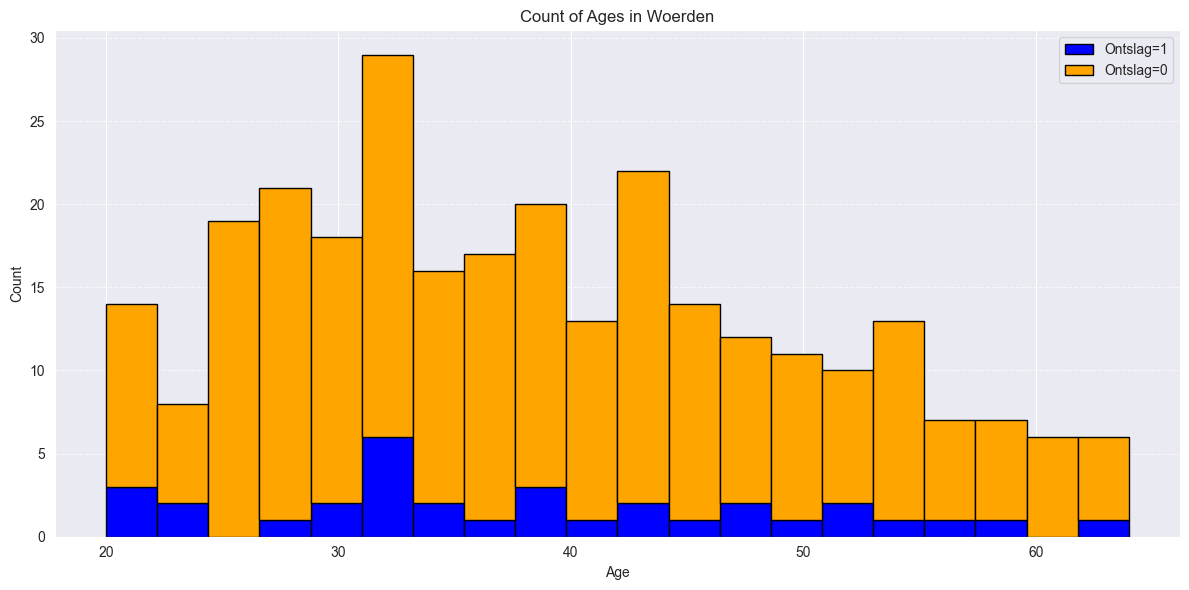

In [74]:
cities_to_plot = ['Alblasserdam', 'Barendrecht', 'Middelburg', 'Veenendaal', 'Woerden']

for city in cities_to_plot:
    df_city = df[df['stad'] == city]

    count_ontslag_1 = df_city[df_city['uitdienst_reden_Ontslag'] == 1]['leeftijd']
    count_ontslag_0 = df_city[df_city['uitdienst_reden_Ontslag'] == 0]['leeftijd']

    plt.figure(figsize=(12, 6))

    plt.hist([count_ontslag_1, count_ontslag_0], bins=20, stacked=True, color=['blue', 'orange'], edgecolor='black', label=['Ontslag=1', 'Ontslag=0'])
    plt.xlabel('Age')
    plt.ylabel('Count')
    plt.title(f'Count of Ages in {city}')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()



In [76]:
#column aantal geboortes aangemaakt
birth_df = pd.read_csv('Datasets/Levend geborenen per duizend inwoners, 2022 (per duizend inwoners)MODIFIED.csv', sep=';')
birth_df
birth_df.replace('Pijnacker-Nootdorp', 'Pijnacker', inplace=True)
birth_df.replace('s-Gravenhage', 'Den Haag', inplace=True)
birth_df.replace('Zaanstad', 'Zaandam', inplace=True)
birth_df.replace('Capelle aan den IJssel', 'Capelle', inplace=True)
# Assuming birth_df and start_df are your DataFrames
merged_df = df.merge(birth_df, left_on='stad', right_on='Gemeente', how='left')
birth_df.info()
# Add the required columns to start_df
df['aantal_geboortes'] = merged_df['Levend geborenen per duizend inwoners']
df['aantal_geboortes_pf'] = merged_df["Levend geborenen per duizend vrouwen (15 tot 50 jaar)"]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 3 columns):
 #   Column                                                 Non-Null Count  Dtype 
---  ------                                                 --------------  ----- 
 0   Gemeente                                               344 non-null    object
 1   Levend geborenen per duizend inwoners                  344 non-null    object
 2   Levend geborenen per duizend vrouwen (15 tot 50 jaar)  344 non-null    object
dtypes: object(3)
memory usage: 8.2+ KB


In [77]:
df.columns

Index(['werknemer_id', 'datum', 'geboortedatum', 'startdatum', 'einddatum',
       'leeftijd', 'dienstperiode', 'stad', 'klant_id', 'geslacht_id',
       'geslacht', 'uitdienst_reden', 'status_jaar', 'status', 'status_Actief',
       'status_Beeindigd', 'afstand_tot_amsterdam',
       'uitdienst_reden_Niet van toepassing', 'uitdienst_reden_Ontslag',
       'uitdienst_reden_Vertrek', 'afdeling_Accountant',
       'afdeling_Administratief medewerker', 'afdeling_BI',
       'afdeling_Boekhouder', 'afdeling_Business analist',
       'afdeling_Business controller', 'afdeling_Business development',
       'afdeling_Credit controller', 'afdeling_Financial controller',
       'afdeling_HR', 'afdeling_IT', 'afdeling_Legal', 'afdeling_Marketing',
       'afdeling_Office manager', 'afdeling_Project controller',
       'business_unit_Detachering', 'business_unit_Intern', 'geslacht_id_Man',
       'geslacht_id_Vrouw', 'aantal_geboortes', 'aantal_geboortes_pf'],
      dtype='object')

## Df goed maken om te trainen

In [78]:
columns_verwijderen = ['werknemer_id', 'klant_id', 'geboortedatum', 'geslacht_id', 'geslacht', 'status', 'geslacht_id_Man', 'geslacht_id_Vrouw', 'stad', 'uitdienst_reden']

# Verwijder de opgegeven kolommen
df = df.drop(columns=columns_verwijderen)

# Laat het resultaat zien
print(df)


                    datum          startdatum           einddatum  leeftijd  \
0     2018-12-31 05:06:00 2013-05-23 05:06:00 1905-01-01 05:06:00      29.0   
1     2016-12-30 05:06:00 2010-04-24 05:06:00 1905-01-01 05:06:00      33.0   
2     2018-12-31 05:06:00 2006-06-09 05:06:00 1905-01-01 05:06:00      42.0   
3     2018-12-31 05:06:00 2018-04-28 05:06:00 1905-01-01 05:06:00      20.0   
4     2013-12-31 05:06:00 2009-01-09 05:06:00 1905-01-01 05:06:00      32.0   
...                   ...                 ...                 ...       ...   
48844 2020-12-30 05:06:00 2013-10-20 05:06:00 1905-01-01 05:06:00      30.0   
48845 2014-12-31 05:06:00 2002-12-20 05:06:00 1905-01-01 05:06:00      45.0   
48846 2020-12-30 05:06:00 1998-03-18 05:06:00 1905-01-01 05:06:00      60.0   
48847 2019-12-31 05:06:00 2008-05-26 05:06:00 1905-01-01 05:06:00      39.0   
48848 2018-12-31 05:06:00 2014-12-08 05:06:00 1905-01-01 05:06:00      26.0   

       dienstperiode  status_jaar  status_Actief  s

In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48849 entries, 0 to 48848
Data columns (total 31 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   datum                                48849 non-null  datetime64[ns]
 1   startdatum                           48849 non-null  datetime64[ns]
 2   einddatum                            48849 non-null  datetime64[ns]
 3   leeftijd                             48849 non-null  float64       
 4   dienstperiode                        48849 non-null  int64         
 5   status_jaar                          48849 non-null  int64         
 6   status_Actief                        48849 non-null  int64         
 7   status_Beeindigd                     48849 non-null  int64         
 8   afstand_tot_amsterdam                48849 non-null  int64         
 9   uitdienst_reden_Niet van toepassing  48849 non-null  uint8         
 10  uitdienst_

In [80]:
new_column_names = {
    'datum': 'datum',
    'startdatum': 'startdatum',
    'einddatum': 'einddatum',
    'leeftijd': 'leeftijd',
    'dienstperiode': 'dienstperiode',
    'status_jaar': 'status_jaar',
    'status_Actief': 'status_actief',
    'status_Beeindigd': 'status_beeindigd',
    'afstand_tot_amsterdam': 'reisafstand',
    'uitdienst_reden_Niet van toepassing': 'uitdienst_reden_nvt',
    'uitdienst_reden_Ontslag': 'uitdienst_reden_ontslag',
    'uitdienst_reden_Vertrek': 'uitdienst_reden_vertrek',
    'afdeling_Accountant': 'afdeling_accountant',
    'afdeling_Administratief medewerker': 'afdeling_administratief_medewerker',
    'afdeling_BI': 'afdeling_bi',
    'afdeling_Boekhouder': 'afdeling_boekhouder',
    'afdeling_Business analist': 'afdeling_business_analist',
    'afdeling_Business controller': 'afdeling_business_controller',
    'afdeling_Business development': 'afdeling_business_development',
    'afdeling_Credit controller': 'afdeling_credit_controller',
    'afdeling_Financial controller': 'afdeling_financial_controller',
    'afdeling_HR': 'afdeling_hr',
    'afdeling_IT': 'afdeling_it',
    'afdeling_Legal': 'afdeling_legal',
    'afdeling_Marketing': 'afdeling_marketing',
    'afdeling_Office manager': 'afdeling_office_manager',
    'afdeling_Project controller': 'afdeling_project_controller',
    'business_unit_Detachering': 'business_unit_detachering',
    'business_unit_Intern': 'business_unit_intern',
    'aantal_geboortes': 'aantal_geboortes',
    'aantal_geboortes_pf': 'aantal_geboortes_pv'
}

# Renaming all columns to Dutch names (lowercase)
df.rename(columns=new_column_names, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48849 entries, 0 to 48848
Data columns (total 31 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   datum                                48849 non-null  datetime64[ns]
 1   startdatum                           48849 non-null  datetime64[ns]
 2   einddatum                            48849 non-null  datetime64[ns]
 3   leeftijd                             48849 non-null  float64       
 4   dienstperiode                        48849 non-null  int64         
 5   status_jaar                          48849 non-null  int64         
 6   status_actief                        48849 non-null  int64         
 7   status_beeindigd                     48849 non-null  int64         
 8   afstand_tot_amsterdam                48849 non-null  int64         
 9   uitdienst_reden_niet_van_toepassing  48849 non-null  uint8         
 10  uitdienst_

In [88]:
for index, value in enumerate(df['aantal_geboortes']):
    chnaged_value = float(value.replace(',', '.'))
    df.at[index, 'aantal_geboortes'] = chnaged_value

AttributeError: 'float' object has no attribute 'replace'

In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48849 entries, 0 to 48848
Data columns (total 31 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   datum                                48849 non-null  datetime64[ns]
 1   startdatum                           48849 non-null  datetime64[ns]
 2   einddatum                            48849 non-null  datetime64[ns]
 3   leeftijd                             48849 non-null  float64       
 4   dienstperiode                        48849 non-null  int64         
 5   status_jaar                          48849 non-null  int64         
 6   status_actief                        48849 non-null  int64         
 7   status_beeindigd                     48849 non-null  int64         
 8   afstand_tot_amsterdam                48849 non-null  int64         
 9   uitdienst_reden_niet_van_toepassing  48849 non-null  uint8         
 10  uitdienst_

In [87]:
for value in df['aantal_geboortes']:
    print(type(value))

<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class '